# Microarray time series

60 samples

## Load packages

In [183]:
setwd("~/work/fibroblast_timecourse")

In [184]:
source("R/002_helper_functions.R")

In [185]:
pacman::p_load(
  fractional,
  dendsort,
  patchwork,
  stringr,
  foreach,
  doMC,
  RColorBrewer,
  data.table,
  reshape2,
  R.utils,
  rjson,
  RCurl,
  scales,
  ggrepel,
  matrixStats,
  viridis,
  dplyr,
  pheatmap,
  seriation
)

pacman::p_load(
  biomaRt,
  limma,
  oligo,
  pd.hugene.1.0.st.v1,
  RSQLite,
  DBI
)
  

sort_hclust <- function(...) { as.hclust(dendsort(as.dendrogram(hclust(...)))) }

Sys.setenv(R_THREADS = 12)
registerDoMC(cores = 12)

In [186]:
theme_set(theme_classic(base_size = 14) %+replace% theme(
  axis.line.y      = element_line(colour = "black", size = 0.2),
  axis.line.x      = element_line(colour = "black", size = 0.2),
  axis.ticks       = element_line(colour = "black", size = 0.2),
  panel.border     = element_rect(size = 0.2, fill = NA),
  strip.background = element_rect(size = 0.2)
))

In [187]:
format_numeric <- function(x, ...) {
  numeric_cols <- vapply(x, is.numeric, logical(1))
  x[numeric_cols] <- lapply(x[numeric_cols], function(x) {
    ix <- abs(x) < 0.01
    x1 <- sprintf("%.3e", x[ix])
    x2 <- sprintf("%.4f", x[!ix])
    x[ix] <- x1
    x[!ix] <- x2
    x
  })
  x
}

## Load data

In [381]:
CEL_FILES <- Sys.glob("data-raw/microarray-data-1/cel/*.CEL.gz")
length(CEL_FILES)

[1] 60

In [382]:
print(head(CEL_FILES))

[1] "data-raw/microarray-data-1/cel/EA10047_314601_HUGENE-1_0-ST-V1_HU.FB.0HR.UNTREATED#1.CEL.gz"
[2] "data-raw/microarray-data-1/cel/EA10047_314602_HUGENE-1_0-ST-V1_HU.FB.0HR.UNTREATED#2.CEL.gz"
[3] "data-raw/microarray-data-1/cel/EA10047_314603_HUGENE-1_0-ST-V1_HU.FB.1HR.MEDIA#1.CEL.gz"    
[4] "data-raw/microarray-data-1/cel/EA10047_314604_HUGENE-1_0-ST-V1_HU.FB.1HR.MEDIA#2.CEL.gz"    
[5] "data-raw/microarray-data-1/cel/EA10047_314605_HUGENE-1_0-ST-V1_HU.FB.1HR.TNF#1.CEL.gz"      
[6] "data-raw/microarray-data-1/cel/EA10047_314606_HUGENE-1_0-ST-V1_HU.FB.1HR.TNF#2.CEL.gz"      


In [383]:
# Get the metadata from the filenames.
meta <- sapply(str_split(CEL_FILES, ".FB."), "[[", 2)
meta <- as.data.frame(t(data.frame(str_split(meta, '\\.'))))[ , 1:2]
rows <- sapply(str_split(basename(CEL_FILES), "-"), "[[", 1)
# rownames(meta) <- sapply(str_split(rows, "_"), "[[", 2)
rownames(meta) <- 1:nrow(meta)
colnames(meta) <- c("Time", "Treatment")
Treatment <- sapply(str_split(meta[ , 2], "#"), "[[", 1)
Replicate <- sapply(str_split(meta[ , 2], "#"), "[[", 2)
meta$Treatment <- Treatment
meta$Treatment <- str_replace(meta$Treatment, "\\+", "_")
meta$Replicate <- Replicate
for (v in colnames(meta)) {
  meta[, v] <- as.factor(meta[, v])
}
# Put the time factor levels in sorted order.
meta$Time <- factor(
  x      = as.numeric(str_replace(meta$Time, "HR", "")),
  levels = sort(as.numeric(unique(str_replace(meta$Time, "HR", ""))))
)

labs <- data.frame(
  Columns = c("Time", "Treatment", "Replicate"),
  labelDescription = c(
    "Time in hours (factor) between treatment and microarray",
    "Treatment, one of: UNTREATED, MEDIA, IL17, TNF, TNF+IL17",
    "Biologic replicate"
  )
)

pd <- AnnotatedDataFrame(meta, labs)

meta$CEL_FILE <- basename(CEL_FILES)

meta[1:5,]

Time,Treatment,Replicate,CEL_FILE
0,UNTREATED,1,EA10047_314601_HUGENE-1_0-ST-V1_HU.FB.0HR.UNTREATED#1.CEL.gz
0,UNTREATED,2,EA10047_314602_HUGENE-1_0-ST-V1_HU.FB.0HR.UNTREATED#2.CEL.gz
1,MEDIA,1,EA10047_314603_HUGENE-1_0-ST-V1_HU.FB.1HR.MEDIA#1.CEL.gz
1,MEDIA,2,EA10047_314604_HUGENE-1_0-ST-V1_HU.FB.1HR.MEDIA#2.CEL.gz
1,TNF,1,EA10047_314605_HUGENE-1_0-ST-V1_HU.FB.1HR.TNF#1.CEL.gz


In [384]:
table(meta$Treatment)


     IL17     MEDIA       TNF  TNF_IL17 UNTREATED 
       14        12        16        16         2 

In [385]:
meta_colors <- list(
  "Treatment" = c(
    "UNTREATED" = 'grey30',
    "MEDIA"     = 'grey70',
    "IL17"      = '#F768A1',
    "TNF"       = '#FEB24C',
    "TNF_IL17"  = '#E31A1C'
  ),
  "Time"      = c(
    '0' = '#440154FF',
    '1' = '#472D7BFF',
    '2' = '#3B528BFF',
    '4' = '#2C728EFF',
    '8' = '#21908CFF',
    '12' = '#27AD81FF',
    '18' = '#5DC863FF',
    '24' = '#AADC32FF',
    '72' = '#FDE725FF'
  ),
  "Replicate" = c(
    "1" = '#66C2A5',
    "2" = '#FC8D62'
  )
)
# for (i in seq_along(levels(meta$Time))) {
#   cat(sprintf("'%s' = '%s',\n", levels(meta$Time)[i], viridis::viridis_pal()(9)[i]))
# }

In [386]:
head(meta)

Time,Treatment,Replicate,CEL_FILE
0,UNTREATED,1,EA10047_314601_HUGENE-1_0-ST-V1_HU.FB.0HR.UNTREATED#1.CEL.gz
0,UNTREATED,2,EA10047_314602_HUGENE-1_0-ST-V1_HU.FB.0HR.UNTREATED#2.CEL.gz
1,MEDIA,1,EA10047_314603_HUGENE-1_0-ST-V1_HU.FB.1HR.MEDIA#1.CEL.gz
1,MEDIA,2,EA10047_314604_HUGENE-1_0-ST-V1_HU.FB.1HR.MEDIA#2.CEL.gz
1,TNF,1,EA10047_314605_HUGENE-1_0-ST-V1_HU.FB.1HR.TNF#1.CEL.gz
1,TNF,2,EA10047_314606_HUGENE-1_0-ST-V1_HU.FB.1HR.TNF#2.CEL.gz


In [387]:
dput(as.numeric(names(table(meta$Time))))

c(0, 1, 2, 4, 8, 12, 18, 24, 72)


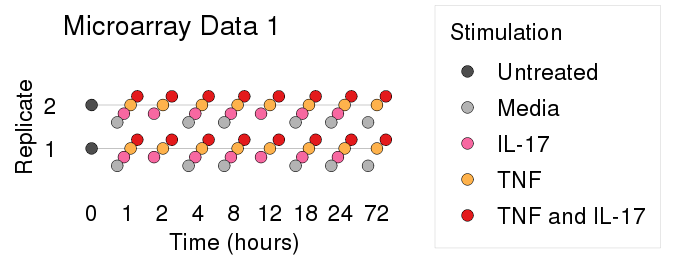

In [388]:
options(repr.plot.width = 4.5, repr.plot.height = 1.8)

d <- meta

d$Time <- as.numeric(as.character(d$Time))
d$Time[d$Time == 4] <- 3
d$Time[d$Time == 8] <- 4
d$Time[d$Time == 12] <- 5
d$Time[d$Time == 18] <- 6
d$Time[d$Time == 24] <- 7
d$Time[d$Time == 72] <- 8
# d$Time[d$Time == 72] <- 30
d$Treatment <- factor(
  x = as.character(d$Treatment),
  levels = c("UNTREATED", "MEDIA", "IL17", "TNF", "TNF_IL17")
)
d$TEMP <- d$Replicate

d$TEMP2 <- as.numeric(as.character(d$Replicate))
d$TEMP2[d$Treatment == "MEDIA"] <- d$TEMP2[d$Treatment == "MEDIA"] - 0.4
d$TEMP2[d$Treatment == "IL17"] <- d$TEMP2[d$Treatment == "IL17"] - 0.2
d$TEMP2[d$Treatment == "TNF_IL17"] <- d$TEMP2[d$Treatment == "TNF_IL17"] + 0.2

p <- ggplot() +
geom_segment(
  data = subset(d, Treatment == "UNTREATED"),
  mapping = aes(x = 0, xend = 8, y = TEMP2, yend = TEMP2),
  size = 0.1, alpha = 0.5
) +
geom_point(
  data = d,
  mapping = aes(x = Time, y = TEMP2, group = Treatment, fill = Treatment),
  shape = 21, stroke = 0.2,
  size = 2.5,
  position = position_dodge(width = 0.75)
) +
scale_fill_manual(
  name = "Stimulation",
  values = meta_colors$Treatment,
  labels = c("Untreated", "Media", "IL-17", "TNF", "TNF and IL-17")
) +
scale_y_continuous(breaks = c(1, 2), limits = c(0, 3)) +
scale_x_continuous(
  breaks = c(0:8),
  labels = c(0, 1, 2, 4, 8, 12, 18, 24, 72)
) +
theme(
  legend.background = element_rect(colour = "grey80", size = 0.1),
  title = element_text(size = 11),
  axis.ticks.length = unit(0, "cm"),
  axis.text = element_text(size = 11, color = "black"),
  legend.text = element_text(size = 11),
  panel.border = element_blank(),
  axis.line.x = element_blank(),
  axis.line.y = element_blank(),
  axis.ticks = element_blank()
) +
labs(title = "Microarray Data 1", x = "Time (hours)", y = "Replicate")

show_plot(p, res = 150)

## Robust Multi-array Averaging (RMA)

In [389]:
microarray_data_file <- "data/microarray.rda"

if (file.exists(microarray_data_file)) {
  load(microarray_data_file)
} else {
  rawData <- oligo::read.celfiles(CEL_FILES, phenoData = pd)
  rmaData <- oligo::rma(rawData)
  plmFit  <- oligo::fitProbeLevelModel(rawData)
  save(list = c("rawData", "rmaData", "plmFit"), file = microarray_data_file)
}

rmaExp <- exprs(rmaData)

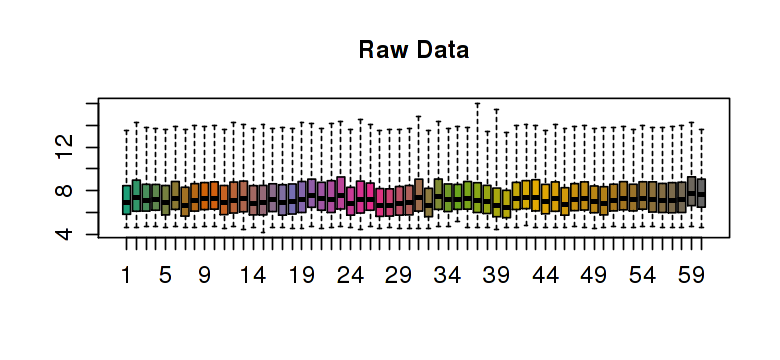

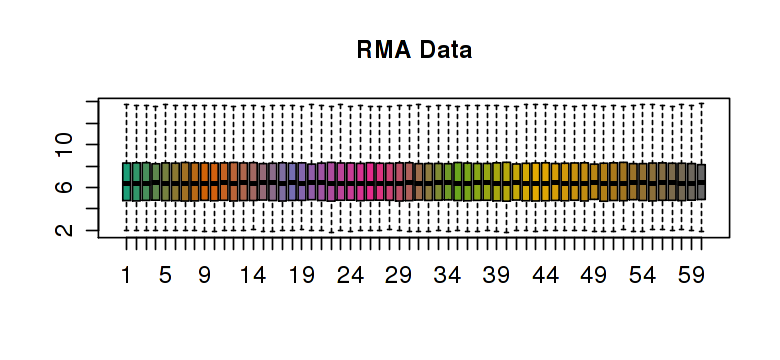

In [390]:
options(repr.plot.width = 6.5, repr.plot.height = 3)

boxplot(rawData, main = "Raw Data", cex.axis = 1.2, cex.lab = 1.2, target = "core")

boxplot(rmaData, main = "RMA Data", cex.axis = 1.2, cex.lab = 1.2, target = "core")

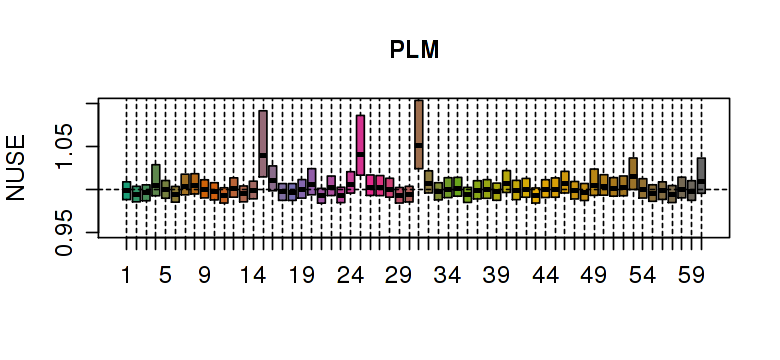

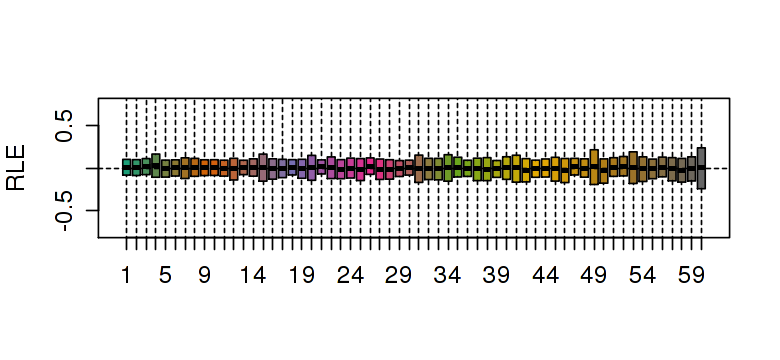

In [391]:
# Normalized Unscaled Standard-Errors (NUSE), should be distributed around 1
NUSE(plmFit, main = "PLM", cex.axis = 1.2, cex.lab = 1.2)

# Relative Log-Expression (RLE), should be distributed around 0
RLE(plmFit, cex.axis = 1.2, cex.lab = 1.2)

## BioMart

In [392]:
mart_dat_file <- "data/microarray_biomart.rds"

array_name <- "affy_hugene_1_0_st_v1"

if (file.exists(mart_dat_file)) {
  mart_dat <- readRDS(mart_dat_file)
} else {
  mart <- useEnsembl(biomart = "ensembl", dataset = "hsapiens_gene_ensembl")
  mart_dat <- getBM(
    mart       = mart,
    values     = rownames(rmaData),
    filters    = c(array_name),
    attributes = c(
      array_name,
      "gene_biotype", "chromosome_name", "start_position", "end_position", "strand",
      "ensembl_gene_id", "entrezgene", "hgnc_id", "hgnc_symbol"
    )
  )
  saveRDS(mart_dat, mart_dat_file)
}

allowed_biotypes <- c("protein_coding", "lincRNA")
mart_dat <- subset(mart_dat, gene_biotype %in% allowed_biotypes)

# Filter out patches, contigs, and novel segments.
allowed_chroms <- as.character(c(1:22, "X", "Y", "MT"))
mart_dat <- subset(mart_dat, chromosome_name %in% allowed_chroms)

# How many probesets do not map to an Ensembl Gene ID?
mart_dat <- unique(mart_dat[!is.na(mart_dat$ensembl_gene_id), ])

# Dictionaries for converting probeset identifiers to other identifiers.
probeset_to_ensembl <- split(mart_dat$ensembl_gene_id, mart_dat[[array_name]])
probeset_to_ensembl <- sapply(probeset_to_ensembl, paste, collapse = ';')
# Exclude probesets that map to multiple Ensembl IDs.
probeset_to_ensembl <- probeset_to_ensembl[grep(";", probeset_to_ensembl, invert = TRUE)]
message(length(probeset_to_ensembl), " probesets with Ensembl Gene IDs")

mart_dat <- mart_dat[mart_dat[[array_name]] %in% names(probeset_to_ensembl),]
message(nrow(mart_dat), " rows in mart_dat")

probeset_to_symbol <- split(mart_dat$hgnc_symbol, mart_dat[[array_name]])
probeset_to_symbol <- sapply(probeset_to_symbol, function(x) { paste(unique(x), collapse = ';') })
print(head(probeset_to_symbol))

# ensembl_to_symbol <- unlist(split(mart_dat$hgnc_symbol, mart_dat$ensembl_gene_id))
ensembl_to_symbol <- with(unique(mart_dat[,c("hgnc_symbol", "ensembl_gene_id")]), unlist(split(hgnc_symbol, ensembl_gene_id)))
print(head(ensembl_to_symbol))

20784 probesets with Ensembl Gene IDs
20784 rows in mart_dat


   7892501    7892506    7892508    7892509    7892512    7892514 
   "RPL17"   "TARDBP"    "RNPS1" "HSP90AB1"      "JTB"     "CANX" 
ENSG00000000003 ENSG00000000005 ENSG00000000419 ENSG00000000457 ENSG00000000460 
       "TSPAN6"          "TNMD"          "DPM1"         "SCYL3"      "C1orf112" 
ENSG00000000938 
          "FGR" 


Get a list of all the attributes we can get out of BioMart:

In [393]:
# x <- listAttributes(mart)
# readr::write_tsv(x, "data-raw/ensembl_biomart_attributes.tsv")

In [394]:
head(mart_dat)

,affy_hugene_1_0_st_v1,gene_biotype,chromosome_name,start_position,end_position,strand,ensembl_gene_id,entrezgene,hgnc_id,hgnc_symbol
27,8165653,protein_coding,MT,3307,4262,1,ENSG00000198888,4535,HGNC:7455,MT-ND1
35,8165658,protein_coding,MT,4470,5511,1,ENSG00000198763,4536,HGNC:7456,MT-ND2
37,7896748,protein_coding,MT,4470,5511,1,ENSG00000198763,4536,HGNC:7456,MT-ND2
75,8165661,protein_coding,MT,5904,7445,1,ENSG00000198804,4512,HGNC:7419,MT-CO1
132,8165686,protein_coding,MT,12337,14148,1,ENSG00000198786,4540,HGNC:7461,MT-ND5
135,8165705,protein_coding,MT,14149,14673,-1,ENSG00000198695,4541,HGNC:7462,MT-ND6


In [395]:
#' Take the mean of all columns of a matrix or dataframe, where rows are
#' aggregated by a vector of values. 100 times faster than stats::aggregate.
#' @param dat A numeric matrix or data.frame.
#' @param xs A vector of groups (e.g. gene names).
#' @return A data.frame with the aggregated mean for each group.
#' @seealso stats::aggregate
mean_by <- function(dat, xs) {
  dat <- data.table(dat)
  dat$agg_var <- xs
  dat <- melt(dat, id.vars = "agg_var")
  dat <- dcast.data.table(
    dat, agg_var ~ variable, value.var = "value",
    fun.aggregate = mean, na.rm = TRUE
  )
  rowns <- dat$agg_var
  dat[ , agg_var := NULL]
  dat <- as.data.frame(dat)
  rownames(dat) <- rowns
  dat
}

# 64% of probesets are assigned an Entrez Gene ID.
# sum(rownames(rmaExp) %in% names(probeset_to_ensembl)) / nrow(rmaExp)
rmaExp <- rmaExp[rownames(rmaExp) %in% names(probeset_to_ensembl), ]

# Aggregate mean probeset expression by Entrez Gene ID.
rmaExp <- mean_by(rmaExp, probeset_to_ensembl[rownames(rmaExp)])

rmaExp <- as.matrix(rmaExp)

In [396]:
rmaExp[1:5,1:5]
dim(rmaExp)

,1,2,3,4,5
ENSG00000000003,8.966649,8.957175,8.979351,8.832811,8.870621
ENSG00000000005,3.815987,3.800270,3.836234,4.016369,3.884919
ENSG00000000419,10.297745,10.161575,10.414260,10.126671,10.345134
ENSG00000000457,8.067284,8.138119,8.170893,7.787470,7.946404
ENSG00000000460,6.797323,6.853342,6.852174,6.567389,6.846737


[1] 17841    60

In [397]:
#' Get an index for extreme values in a vector.
#' @param xs A numeric vector.
#' @param low The lower quantile.
#' @param high The upper quantile.
#' @return A boolean vector indicating items below or above the quantiles.
extreme_idx <- function(xs, low = 0.005, high = 0.995) {
  qs <- quantile(xs, probs = c(low, high))
  xs < qs[1] | xs > qs[2]
}

notna    <- function(xs) xs[!is.na(xs)]
negative <- function(xs) xs[xs < 0]
positive <- function(xs) xs[xs > 0]

lt <- function(xs, x) xs[xs < x]
gt <- function(xs, x) xs[xs > x]

In [398]:
# https://stackoverflow.com/questions/31677923/set-0-point-for-pheatmap-in-r
get_breaks <- function(test, paletteLength) {
  myColor <- colorRampPalette(c("red", "white", "blue"))(paletteLength)
  # use floor and ceiling to deal with even/odd length pallette lengths
  c(
    seq(min(test), 0, length.out = ceiling(paletteLength / 2) + 1), 
    seq(max(test) / paletteLength, max(test), length.out = floor(paletteLength / 2))
  )
}

my_breaks <- function(xs, n = 20, method = 'symmetric') {
  if (method == 'symmetric') {
    neg_max <- min(xs[xs < 0])
    pos_max <- max(xs[xs > 0])
    abs_max_sign <- ifelse(abs(neg_max) > pos_max, -1, 1)
    abs_max <- max(abs(xs))
    ret_breaks <- seq(-abs_max, abs_max, length.out = n)
    ret_colors <- colorRampPalette(rev(brewer.pal(n = 7, name = "RdBu")))(n)
    if (abs_max_sign == 1) {
      ix <- tail(which(ret_breaks < neg_max), 1):length(ret_breaks)
      ret_breaks <- ret_breaks[ix]
      ret_colors <- ret_colors[ix]
    } else {
      ix <- 1:head(which(ret_breaks > pos_max), 1)
      ret_breaks <- ret_breaks[ix]
      ret_colors <- ret_colors[ix]
    }
  }
  list("breaks" = ret_breaks, "colors" = ret_colors)
}

# Get density of points in 2 dimensions.
# @param x A numeric vector.
# @param y A numeric vector.
# @param n Create a square n by n grid to compute density.
# @return The density within each square.
get_density <- function(x, y, n = 100) {
  dens <- MASS::kde2d(x = x, y = y, n = n)
  ix <- findInterval(x, dens$x)
  iy <- findInterval(y, dens$y)
  ii <- cbind(ix, iy)
  return(dens$z[ii])
}

plot_geneset_median <- function(geneset, meta, log2tpm, ci = 0.5) {
    if (!grepl("^ENSG", geneset[1])) {
        gene <- names(which(gene_symbols %in% geneset))
        stopifnot(length(geneset) > 1)
    }
    geneset <- geneset[geneset %in% rownames(log2tpm)]
    dat <- data.frame(Time = meta[["Time"]], t(log2tpm[geneset, ]))
    x <- dat[dat$Time == 0, ]
    dat_zero <- rbind(x, x, x)
    dat <- rbind(dat, dat_zero)
    dat$Time <- factor(dat$Time)
    dat_median <- reshape2::melt(dat, id.vars = c("Time")) %>%
      group_by(Time, variable) %>% 
      summarise(mean = mean(value)) %>%
      group_by(Time) %>%
      summarise(
        median = median(mean),
        low = quantile(mean, probs = (1 - ci)/2),
        high = quantile(mean, probs = 1 - ((1 - ci)/2))
      )
    ggplot(data = dat_median, mapping = aes(x = Time, y = median, ymin = low, ymax = high, group = 1)) + 
    geom_line(size = 1) +
    geom_ribbon(alpha = 0.15, fill = "black", color = NA) +
    theme_bw(base_size = font_size) + 
    labs(x = "Hours", y = bquote("Log"[2] ~ "TPM")) +
    theme(
      panel.grid.major = element_line(color = "grey60", size = 0.1),
      panel.grid.minor = element_blank()
    )
}

## Quality control with common genes

In [399]:
median_val <- median(rmaExp)

common_genes <- names(which(apply(
  X = rmaExp,
  MARGIN = 1,
  FUN = function(x) sum(x > median_val) > ceiling(0.9 * ncol(rmaExp))
)))

meta$common_percent <- apply(
  X = rmaExp[common_genes,],
  MARGIN = 2,
  FUN = function(x) sum(x > median_val)
) / length(common_genes)

In [400]:
meta$Sample <- colnames(rmaExp)
head(meta)

Time,Treatment,Replicate,CEL_FILE,common_percent,Sample
0,UNTREATED,1,EA10047_314601_HUGENE-1_0-ST-V1_HU.FB.0HR.UNTREATED#1.CEL.gz,0.9993664,1
0,UNTREATED,2,EA10047_314602_HUGENE-1_0-ST-V1_HU.FB.0HR.UNTREATED#2.CEL.gz,0.9996198,2
1,MEDIA,1,EA10047_314603_HUGENE-1_0-ST-V1_HU.FB.1HR.MEDIA#1.CEL.gz,0.9989862,3
1,MEDIA,2,EA10047_314604_HUGENE-1_0-ST-V1_HU.FB.1HR.MEDIA#2.CEL.gz,0.9969586,4
1,TNF,1,EA10047_314605_HUGENE-1_0-ST-V1_HU.FB.1HR.TNF#1.CEL.gz,0.9986060,5
1,TNF,2,EA10047_314606_HUGENE-1_0-ST-V1_HU.FB.1HR.TNF#2.CEL.gz,0.9983526,6


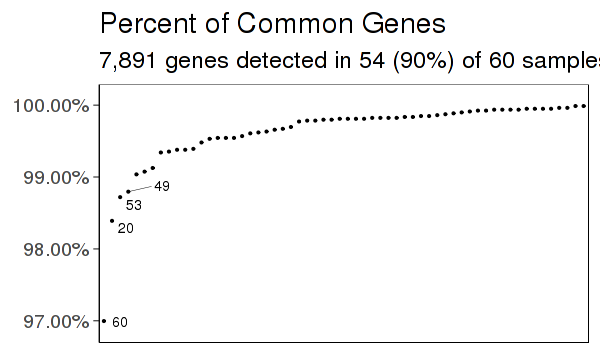

In [401]:
options(repr.plot.width = 5, repr.plot.height = 3)

ggplot(meta, aes(x = reorder(Sample, common_percent), y = common_percent, label = Sample)) +
  geom_point(size = 0.1) +
  geom_text_repel(
    data = subset(meta, common_percent < 0.99),
    nudge_x = 2,
    segment.size = 0.1,
    size = 3
  ) +
#  geom_hline(yintercept = 0.9, color = "red", linetype = 2) +
  scale_y_continuous(labels = percent, expand = c(0.1, 0)) +
  scale_x_discrete(expand = c(0.01, 0)) +
  theme(
    axis.ticks.x = element_blank(),
    axis.text.x = element_blank(),
#    panel.grid.major.y = element_line(size = 0.03, color = 'black'),
    axis.line.x = element_blank()
  ) +
  labs(
    x = NULL, y = NULL, title = "Percent of Common Genes",
    subtitle = sprintf(
      "%s genes detected in %s (90%%) of %s samples",
      comma(length(common_genes)),
      ceiling(nrow(meta) * 0.9), nrow(meta)
    )
  )

In [402]:
subset(meta, common_percent < 0.99)

,Time,Treatment,Replicate,CEL_FILE,common_percent,Sample
20,4,TNF,2,EA10047_314620_HUGENE-1_0-ST-V1_HU.FB.4HR.TNF#2.CEL.gz,0.9839057,20
49,24,TNF,1,EA10047_314649_HUGENE-1_0-ST-V1_HU.FB.24HR.TNF#1.CEL.gz,0.9879610,49
53,24,TNF_IL17,1,EA10047_314653_HUGENE-1_0-ST-V1_HU.FB.24HR.TNF+IL17#1.CEL.gz,0.9872006,53
60,72,TNF_IL17,2,EA10047_314660_HUGENE-1_0-ST-V1_HU.FB.72HR.TNF+IL17#2.CEL.gz,0.9699658,60


In [403]:
gene_summary <- data.frame(
  mean = rowMeans(rmaExp),
  sd   = rowSds(rmaExp)
)
gene_summary$density <- with(gene_summary, get_density(mean, sd))

In [404]:
ix_exclude <- gene_summary$sd < quantile(gene_summary$sd, probs = 0.25) &
              gene_summary$mean < quantile(gene_summary$mean, probs = 0.25)

sum(ix_exclude)
sum(ix_exclude) / length(ix_exclude)

[1] 1220

[1] 0.06838182

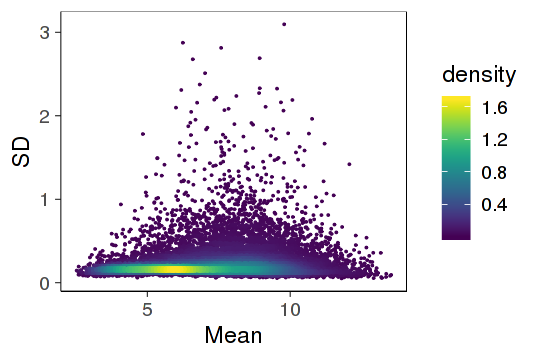

In [405]:
options(repr.plot.width = 4.5, repr.plot.height = 3)

ggplot(gene_summary[order(gene_summary$density),], aes(mean, sd, color = density)) +
scale_color_viridis() +
geom_point(size = 0.01) +
# geom_hline(yintercept = quantile(gene_summary$sd, probs = 0.25), color = "red", size = 0.2) +
# geom_vline(xintercept = quantile(gene_summary$mean, probs = 0.25), color = "red", size = 0.2) +
labs(
  x = "Mean",
  y = "SD"
#   subtitle = sprintf(
#     "Exclude %s (%s) lowly expressed genes",
#     comma(sum(ix_exclude)),
#     percent(sum(ix_exclude) / length(ix_exclude))
#   )
)

In [406]:
m_exp <- rmaExp
m_meta <- meta

In [407]:
m_meta$TreatTime <- sprintf("%s_%s", m_meta$Treatment, m_meta$Time)
head(m_meta)

Time,Treatment,Replicate,CEL_FILE,common_percent,Sample,TreatTime
0,UNTREATED,1,EA10047_314601_HUGENE-1_0-ST-V1_HU.FB.0HR.UNTREATED#1.CEL.gz,0.9993664,1,UNTREATED_0
0,UNTREATED,2,EA10047_314602_HUGENE-1_0-ST-V1_HU.FB.0HR.UNTREATED#2.CEL.gz,0.9996198,2,UNTREATED_0
1,MEDIA,1,EA10047_314603_HUGENE-1_0-ST-V1_HU.FB.1HR.MEDIA#1.CEL.gz,0.9989862,3,MEDIA_1
1,MEDIA,2,EA10047_314604_HUGENE-1_0-ST-V1_HU.FB.1HR.MEDIA#2.CEL.gz,0.9969586,4,MEDIA_1
1,TNF,1,EA10047_314605_HUGENE-1_0-ST-V1_HU.FB.1HR.TNF#1.CEL.gz,0.9986060,5,TNF_1
1,TNF,2,EA10047_314606_HUGENE-1_0-ST-V1_HU.FB.1HR.TNF#2.CEL.gz,0.9983526,6,TNF_1


In [408]:
table(m_meta$Treatment, m_meta$Time)

           
            0 1 2 4 8 12 18 24 72
  IL17      0 2 2 2 2  2  2  2  0
  MEDIA     0 2 0 2 2  0  2  2  2
  TNF       0 2 2 2 2  2  2  2  2
  TNF_IL17  0 2 2 2 2  2  2  2  2
  UNTREATED 2 0 0 0 0  0  0  0  0

In [415]:
(
  m_meta %>%
  dplyr::select(Sample, CEL_FILE) %>%
  mutate(Sample = sprintf("S%s", Sample))
)$CEL_FILE %>% cat(sep = "\n")

EA10047_314601_HUGENE-1_0-ST-V1_HU.FB.0HR.UNTREATED#1.CEL.gz
EA10047_314602_HUGENE-1_0-ST-V1_HU.FB.0HR.UNTREATED#2.CEL.gz
EA10047_314603_HUGENE-1_0-ST-V1_HU.FB.1HR.MEDIA#1.CEL.gz
EA10047_314604_HUGENE-1_0-ST-V1_HU.FB.1HR.MEDIA#2.CEL.gz
EA10047_314605_HUGENE-1_0-ST-V1_HU.FB.1HR.TNF#1.CEL.gz
EA10047_314606_HUGENE-1_0-ST-V1_HU.FB.1HR.TNF#2.CEL.gz
EA10047_314607_HUGENE-1_0-ST-V1_HU.FB.1HR.IL17#1.CEL.gz
EA10047_314608_HUGENE-1_0-ST-V1_HU.FB.1HR.IL17#2.CEL.gz
EA10047_314609_HUGENE-1_0-ST-V1_HU.FB.1HR.TNF+IL17#1.CEL.gz
EA10047_314610_HUGENE-1_0-ST-V1_HU.FB.1HR.TNF+IL17#2.CEL.gz
EA10047_314611_HUGENE-1_0-ST-V1_HU.FB.2HR.TNF#1.CEL.gz
EA10047_314612_HUGENE-1_0-ST-V1_HU.FB.2HR.TNF#2.CEL.gz
EA10047_314613_HUGENE-1_0-ST-V1_HU.FB.2HR.IL17#1.CEL.gz
EA10047_314614_HUGENE-1_0-ST-V1_HU.FB.2HR.IL17#2.CEL.gz
EA10047_314615_HUGENE-1_0-ST-V1_HU.FB.2HR.TNF+IL17#1.CEL.gz
EA10047_314616_HUGENE-1_0-ST-V1_HU.FB.2HR.TNF+IL17#2.CEL.gz
EA10047_314617_HUGENE-1_0-ST-V1_HU.FB.4HR.MEDIA#1.CEL.gz
EA10047_314618_HUGENE-1

# Export for NCBI GEO

In [351]:
write_matrix <- function(x, path) {
  colnames(x) <- sprintf("S%s", colnames(x))
  x <- data.frame(
    ID_REF = rownames(x),
    x,
    stringsAsFactors = FALSE
  )
  rownames(x) <- NULL
  readr::write_tsv(x, path)
}

###

out_dir <- "share/NCBI-GEO/microarray-data-1"
dir.create(out_dir, showWarnings = FALSE, recursive = TRUE)

###

rmaExp_file <- sprintf("%s/microarray-data-1_gene-expression.tsv.gz", out_dir)
write_matrix(rmaExp, rmaExp_file)

print(rmaExp_file)
cat(paste(system(sprintf("zcat %s | head | cut -f1-5 | column -t", rmaExp_file), intern = TRUE), collapse = "\n"))
cat("\n\n")

###

probeExp <- exprs(rmaData)
probeExp_file <- sprintf("%s/microarray-data-1_probe-expression.tsv.gz", out_dir)
write_matrix(probeExp, probeExp_file)

print(probeExp_file)
cat(paste(system(sprintf("zcat %s | head | cut -f1-5 | column -t", probeExp_file), intern = TRUE), collapse = "\n"))
cat("\n\n")

###

meta_cols <- c(
  "Sample",
  "Replicate",
  "Treatment",
  "Time"
)
x <- meta[,meta_cols]
x$Sample <- sprintf("S%s", x$Sample)
meta_file <- sprintf("%s/microarray-data-1_metadata.tsv", out_dir)
readr::write_tsv(x, meta_file)

print(meta_file)
cat(paste(system(sprintf("cat %s | head | column -t", meta_file), intern = TRUE), collapse = "\n"))
cat("\n\n")


[1] "share/NCBI-GEO/microarray-data-1/microarray-data-1_gene-expression.tsv.gz"
ID_REF           S1                  S2                  S3                  S4
ENSG00000000003  8.966649089835375   8.957174795765253   8.979351119795444   8.832810665504002
ENSG00000000005  3.8159867530708618  3.800269875572857   3.836233770060404   4.016369295222935
ENSG00000000419  10.297744844507953  10.16157515137798   10.414260207761101  10.126671359985284
ENSG00000000457  8.067284154190876   8.138119032204498   8.17089269115757    7.787469812264447
ENSG00000000460  6.797322726974915   6.853341997751063   6.852174168893821   6.5673888765883985
ENSG00000000938  6.740990543773398   6.778366199269415   6.673238260926288   6.879187909049238
ENSG00000000971  10.015193009387039  10.010284214588399  10.092165053188518  9.966963136962518
ENSG00000001036  8.938993126659419   8.919404045665942   8.914416726794974   8.812891756621285
ENSG00000001084  8.760744975975058   8.65405753671887    8.71236291433238    8

## Linear modeling with treatment-time

In [215]:
m_des <- with(
  m_meta,
  model.matrix(~ 0 + TreatTime)
)
colnames(m_des) <- str_replace_all(colnames(m_des), "TreatTime", "")
# colnames(m_des) <- str_replace_all(colnames(m_des), "Time", "T")

m_fit <- lmFit(object = m_exp, design = m_des)
m_fit <- eBayes(m_fit)
m_fit$genes <- ensembl_to_symbol[rownames(m_fit$coefficients)]

# m_treat_cols <- grep("^dose", colnames(m_fit$coefficients), value = TRUE)
# m_time_cols  <- grep("^time", colnames(m_fit$coefficients), value = TRUE)

save(
  list = c("m_des", "m_fit", "m_exp", "m_meta"),
  file = "data/microarray_limma.rda"
)

In [216]:
m_fit_signif <- decideTests(m_fit, lfc = log2(2), p.value = 0.05)

do.call(rbind, apply(m_fit_signif, 2, function(x) {
  data.frame(
    "Up"        = sum(x == 1),
    "Down"      = sum(x == -1),
    "Unchanged" = sum(x == 0)
  )
}))

,Up,Down,Unchanged
IL17_1,17841,0,0
IL17_12,17841,0,0
IL17_18,17841,0,0
IL17_2,17841,0,0
IL17_24,17841,0,0
IL17_4,17841,0,0
IL17_8,17841,0,0
MEDIA_1,17841,0,0
MEDIA_18,17841,0,0
MEDIA_24,17841,0,0


In [217]:
m_meta$Stim <- m_meta$Treatment
m_meta$Stim[m_meta$Stim == "UNTREATED"] <- "MEDIA"

ix_nozero <- which(m_meta$Time != 0)
m_meta$Time <- as.character(m_meta$Time)
m_meta$Stim <- as.character(m_meta$Stim)

m_des2 <- with(
  m_meta[ix_nozero,],
  model.matrix(~ 0 + Stim + Time)
)
colnames(m_des2) <- str_replace_all(colnames(m_des2), "Stim", "")

m_fit2 <- lmFit(object = m_exp[,ix_nozero], design = m_des2)
m_fit2 <- eBayes(m_fit2)
m_fit2$genes <- ensembl_to_symbol[rownames(m_fit2$coefficients)]

print(colnames(m_fit2$coefficients))

topTable(m_fit2, coef = "TNF")

 [1] "IL17"     "MEDIA"    "TNF"      "TNF_IL17" "Time12"   "Time18"  
 [7] "Time2"    "Time24"   "Time4"    "Time72"   "Time8"   


,ID,logFC,AveExpr,t,P.Value,adj.P.Val,B
ENSG00000111640,GAPDH,13.18255,13.20680,558.9856,2.798505e-99,2.633702e-95,200.7712
ENSG00000140545,MFGE8,12.34203,12.31610,558.4059,2.952416e-99,2.633702e-95,200.7451
ENSG00000113140,SPARC,13.23335,13.18159,551.6420,5.537103e-99,3.292915e-95,200.4363
ENSG00000150991,UBC,13.21486,13.19848,522.4065,9.195164e-98,4.101273e-94,199.0088
ENSG00000102265,TIMP1,13.34306,13.35141,510.6699,2.970005e-97,9.151330e-94,198.3900
ENSG00000142192,APP,12.09385,12.15099,510.3177,3.077629e-97,9.151330e-94,198.3710
ENSG00000104904,OAZ1,12.94117,12.91638,501.5106,7.556670e-97,1.925979e-93,197.8875
ENSG00000130175,PRKCSH,11.35417,11.40925,488.1820,3.033540e-96,6.502196e-93,197.1238
ENSG00000182492,BGN,13.06085,13.03831,487.4433,3.280072e-96,6.502196e-93,197.0803
ENSG00000064601,CTSA,12.06510,12.08361,479.5045,7.653309e-96,1.365427e-92,196.6048


In [218]:
m_fit2_signif <- decideTests(m_fit2, lfc = log2(2), p.value = 0.05)

do.call(rbind, apply(m_fit2_signif, 2, function(x) {
  data.frame(
    "Up"        = sum(x == 1),
    "Down"      = sum(x == -1),
    "Unchanged" = sum(x == 0)
  )
}))

,Up,Down,Unchanged
IL17,17841,0,0
MEDIA,17841,0,0
TNF,17841,0,0
TNF_IL17,17841,0,0
Time12,181,66,17594
Time18,221,90,17530
Time2,8,11,17822
Time24,214,135,17492
Time4,39,29,17773
Time72,270,243,17328


In [219]:
print(colnames(m_des))

 [1] "IL17_1"      "IL17_12"     "IL17_18"     "IL17_2"      "IL17_24"    
 [6] "IL17_4"      "IL17_8"      "MEDIA_1"     "MEDIA_18"    "MEDIA_24"   
[11] "MEDIA_4"     "MEDIA_72"    "MEDIA_8"     "TNF_1"       "TNF_12"     
[16] "TNF_18"      "TNF_2"       "TNF_24"      "TNF_4"       "TNF_72"     
[21] "TNF_8"       "TNF_IL17_1"  "TNF_IL17_12" "TNF_IL17_18" "TNF_IL17_2" 
[26] "TNF_IL17_24" "TNF_IL17_4"  "TNF_IL17_72" "TNF_IL17_8"  "UNTREATED_0"


In [220]:
topTable(m_fit, coef = "TNF_IL17_18")

,ID,logFC,AveExpr,t,P.Value,adj.P.Val,B
ENSG00000087245,MMP2,13.18139,12.99514,352.2716,6.828311e-66,7.488708e-62,129.1933
ENSG00000234745,HLA-B,12.88579,12.41495,350.2773,8.394942e-66,7.488708e-62,129.0943
ENSG00000140545,MFGE8,12.31236,12.31873,341.4043,2.135062e-65,1.269721e-61,128.6392
ENSG00000206503,HLA-A,12.84912,12.48548,338.4552,2.927446e-65,1.305714e-61,128.4826
ENSG00000111640,GAPDH,13.25571,13.20698,335.1792,4.170281e-65,1.488040e-61,128.3053
ENSG00000026508,CD44,12.94274,12.83128,322.8170,1.636475e-64,4.774663e-61,127.6038
ENSG00000182492,BGN,13.04108,13.04103,321.6196,1.873361e-64,4.774663e-61,127.5330
ENSG00000142156,COL6A1,11.93160,11.96946,318.0710,2.804898e-64,6.255273e-61,127.3201
ENSG00000113140,SPARC,13.15278,13.18469,316.0276,3.546018e-64,7.029390e-61,127.1953
ENSG00000120708,TGFBI,12.47761,12.23876,314.3451,4.306077e-64,7.682472e-61,127.0914


## TNF effects and TNF+IL17 effects

In [221]:
m_con2 <- makeContrasts(
  levels  = m_des,
#   DIF2  = (TNF_IL17_2 - TNF_IL17_1) - (TNF_2 - TNF_1),
#   DIF4  = (TNF_IL17_4 - TNF_IL17_1) - (TNF_4 - TNF_1),
#   DIF8  = (TNF_IL17_8 - TNF_IL17_1) - (TNF_8 - TNF_1),
#   DIF12 = (TNF_IL17_12 - TNF_IL17_1) - (TNF_12 - TNF_1),
  DIF18 = TNF_IL17_18 - TNF_18,
  TNF18 = TNF_18 - MEDIA_18
#   DIF24 = (TNF_IL17_24 - TNF_IL17_1) - (TNF_24 - TNF_1),
#   DIF72 = (TNF_IL17_72 - TNF_IL17_1) - (TNF_72 - TNF_1)
)
m_con2 <- contrasts.fit(m_fit, m_con2)
m_con2 <- eBayes(m_con2)
m_con2$genes <- ensembl_to_symbol[rownames(m_con2$coefficients)]

dat_il17 <- topTable(m_con2, coef = "DIF18", number = 1e6)
dat_il17 <- dat_il17[order(rownames(dat_il17)),]

dat_tnf <- topTable(m_con2, coef = "TNF18", number = 1e6)
dat_tnf <- dat_tnf[order(rownames(dat_tnf)),]

stopifnot(all(rownames(dat_il17) == rownames(dat_tnf)))

dat <- data.frame(
  gene = dat_il17$ID,
  IL17 = dat_il17$logFC,
  IL17_pval = dat_il17$P.Value,
  IL17_qval = dat_il17$adj.P.Val,
  TNF  = dat_tnf$logFC,
  TNF_pval = dat_tnf$P.Value,
  TNF_qval = dat_tnf$adj.P.Val
)

In [222]:
dat$signif <- abs(dat$IL17) > log2(2) | abs(dat$TNF) > log2(2)

dat %>% arrange(TNF_pval) %>% head

gene,IL17,IL17_pval,IL17_qval,TNF,TNF_pval,TNF_qval,signif
MMP1,-0.1025360,0.267795259,0.8109050,4.744709,8.876184e-36,1.583600e-31,TRUE
CCL5,-0.2200503,0.121036561,0.6599876,6.100012,3.694351e-33,2.251697e-29,TRUE
SLC14A1,-0.2229932,0.041422988,0.4434281,-4.638801,3.786274e-33,2.251697e-29,TRUE
MARCH3,-0.1264203,0.206264979,0.7619071,4.048657,3.847853e-32,1.716238e-28,TRUE
CXCL8,0.1532487,0.358478877,0.8597662,6.506152,1.768808e-31,6.311460e-28,TRUE
CMKLR1,0.2944431,0.008035377,0.1872500,-4.027047,4.953709e-31,1.472985e-27,TRUE


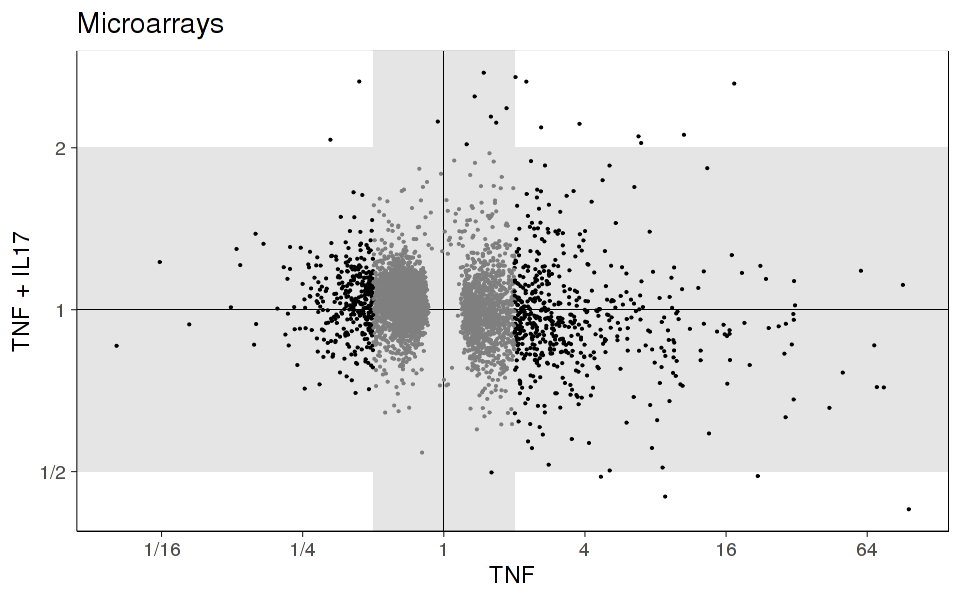

In [223]:
options(repr.plot.width = 8, repr.plot.height = 5)

dat %>% filter(TNF_qval < 0.005 | IL17_qval < 0.005) %>%
ggplot(aes(x = TNF, y = IL17)) +
geom_rect(
  mapping = aes(
    xmin = log2(1 / 2),
    xmax = log2(2),
    ymin = -Inf,
    ymax = Inf
  ),
  fill = "grey90"
) +
geom_rect(
  mapping = aes(
    ymin = log2(1 / 2),
    ymax = log2(2),
    xmin = -Inf,
    xmax = Inf
  ),
  fill = "grey90"
) +
geom_hline(yintercept = 0, size = 0.2) +
geom_vline(xintercept = 0, size = 0.2) +
geom_point(aes(color = signif), size = 0.1) +
scale_color_manual(values = c("grey50", "black")) +
theme(legend.position = "none") +
scale_x_continuous(
  breaks = pretty_breaks(5),
  labels = function(x) fractional(2^x)
) +
scale_y_continuous(
  breaks = pretty_breaks(4),
  labels = function(x) fractional(2^x)
) +
# geom_text(
#   data = subset(dat, IL17 > log2(2) & abs(TNF) > log2(2)),
#   mapping = aes(x = TNF, y = IL17, label = gene)
# ) +
labs(x = "TNF", y = "TNF + IL17", title = "Microarrays")

In [224]:
subset(dat, IL17 > log2(2) & abs(TNF) < log2(2))

,gene,IL17,IL17_pval,IL17_qval,TNF,TNF_pval,TNF_qval,signif
3644,SLC1A2,1.021708,8.278790e-08,3.210911e-05,0.32255061,4.196668e-02,9.631176e-02,TRUE
4460,CTH,1.244518,2.103200e-11,4.169243e-08,0.88774620,6.006226e-08,6.105817e-07,TRUE
6626,RERG,1.155049,4.730117e-08,1.962559e-05,0.74213951,8.855612e-05,4.592819e-04,TRUE
6926,EDNRB,1.463399,1.018959e-12,3.635848e-09,0.56482689,2.182355e-04,1.034141e-03,TRUE
8975,SLC2A13,1.192502,2.124134e-14,1.263222e-10,0.66635094,5.614610e-08,5.747003e-07,TRUE
9729,HPD,1.161992,3.767826e-10,3.734543e-07,-0.08598918,5.339401e-01,6.535867e-01,TRUE
10491,ELF3,1.317124,3.036735e-10,3.386149e-07,0.43612001,7.442721e-03,2.274505e-02,TRUE


In [225]:
dat_il17[which(abs(dat_tnf$logFC) < log2(1.5) & dat_il17$logFC > log2(1.5)),]

,ID,logFC,AveExpr,t,P.Value,adj.P.Val,B
ENSG00000036672,USP2,0.6400170,6.751499,5.603807,2.274660e-06,4.664621e-04,4.800806
ENSG00000049192,ADAMTS6,0.6043119,7.807421,4.331489,1.114748e-04,9.470579e-03,1.117393
ENSG00000064309,CDON,0.7419509,9.710904,8.642509,2.402192e-10,2.857167e-07,13.447071
ENSG00000103044,HAS3,0.7630929,6.619077,6.742784,6.785537e-08,2.751381e-05,8.132461
ENSG00000103154,NECAB2,0.9213850,6.580263,5.691516,1.733928e-06,3.731807e-04,5.058420
ENSG00000110436,SLC1A2,1.0217084,5.578666,6.677786,8.278790e-08,3.210911e-05,7.944035
ENSG00000115556,PLCD4,0.6001520,6.990068,5.120941,1.010370e-05,1.489753e-03,3.386540
ENSG00000119915,ELOVL3,0.8318507,5.757192,6.140259,4.327468e-07,1.225498e-04,6.375728
ENSG00000127954,STEAP4,0.8702990,9.693684,6.156616,4.114301e-07,1.195146e-04,6.423659
ENSG00000131386,GALNT15,0.6564522,6.959782,4.553835,5.710743e-05,5.507317e-03,1.747966


## TNF+IL17 vs TNF at each time point

In [226]:
m_con1 <- makeContrasts(
  levels  = m_des,
  DIF2  = (TNF_IL17_2 - TNF_IL17_1) - (TNF_2 - TNF_1),
  DIF4  = (TNF_IL17_4 - TNF_IL17_1) - (TNF_4 - TNF_1),
  DIF8  = (TNF_IL17_8 - TNF_IL17_1) - (TNF_8 - TNF_1),
  DIF12 = (TNF_IL17_12 - TNF_IL17_1) - (TNF_12 - TNF_1),
  DIF18 = (TNF_IL17_18 - TNF_IL17_1) - (TNF_18 - TNF_1),
  DIF24 = (TNF_IL17_24 - TNF_IL17_1) - (TNF_24 - TNF_1),
  DIF72 = (TNF_IL17_72 - TNF_IL17_1) - (TNF_72 - TNF_1)
)
m_con1 <- contrasts.fit(m_fit, m_con1)
m_con1 <- eBayes(m_con1)
m_con1$genes <- ensembl_to_symbol[rownames(m_con1$coefficients)]

In [227]:
top <- topTable(m_con1, coef = "DIF18")
#top$Gene <- ensembl_to_symbol[rownames(top)]
top

,ID,logFC,AveExpr,t,P.Value,adj.P.Val,B
ENSG00000005249,PRKAR2B,1.7129591,6.611493,10.704893,8.529270e-13,1.521707e-08,17.628133
ENSG00000151229,SLC2A13,1.2811507,8.079966,9.251148,4.294746e-11,3.831128e-07,14.335073
ENSG00000137872,SEMA6D,1.0018913,7.920368,8.538366,3.239976e-10,1.926814e-06,12.595486
ENSG00000129988,LBP,1.2913323,6.111138,8.250298,7.462625e-10,3.328517e-06,11.869949
ENSG00000136160,EDNRB,1.4771414,7.655266,7.591867,5.205831e-09,1.362305e-05,10.165924
ENSG00000141338,ABCA8,1.4448769,6.227919,7.588424,5.259616e-09,1.362305e-05,10.156855
ENSG00000181634,TNFSF15,-0.9415711,8.868736,-7.538424,6.107167e-09,1.362305e-05,10.024979
ENSG00000158104,HPD,1.4597916,6.177372,7.538343,6.108650e-09,1.362305e-05,10.024765
ENSG00000153721,CNKSR3,-1.1110699,7.405243,-6.847732,4.924607e-08,8.855289e-05,8.171858
ENSG00000172572,PDE3A,0.9678444,8.091406,6.845157,4.963449e-08,8.855289e-05,8.164848


In [228]:
m_decide1 <- decideTests(m_con1, lfc = log2(1.5), p.value = 0.005)

il17_time_genes <- names(which(colSums(apply(m_decide1, 1, function(x) x != 0)) >= 2))
length(il17_time_genes)

[1] 87

In [229]:
median(m_exp)

[1] 7.181524

[1]  3.806077 13.123565

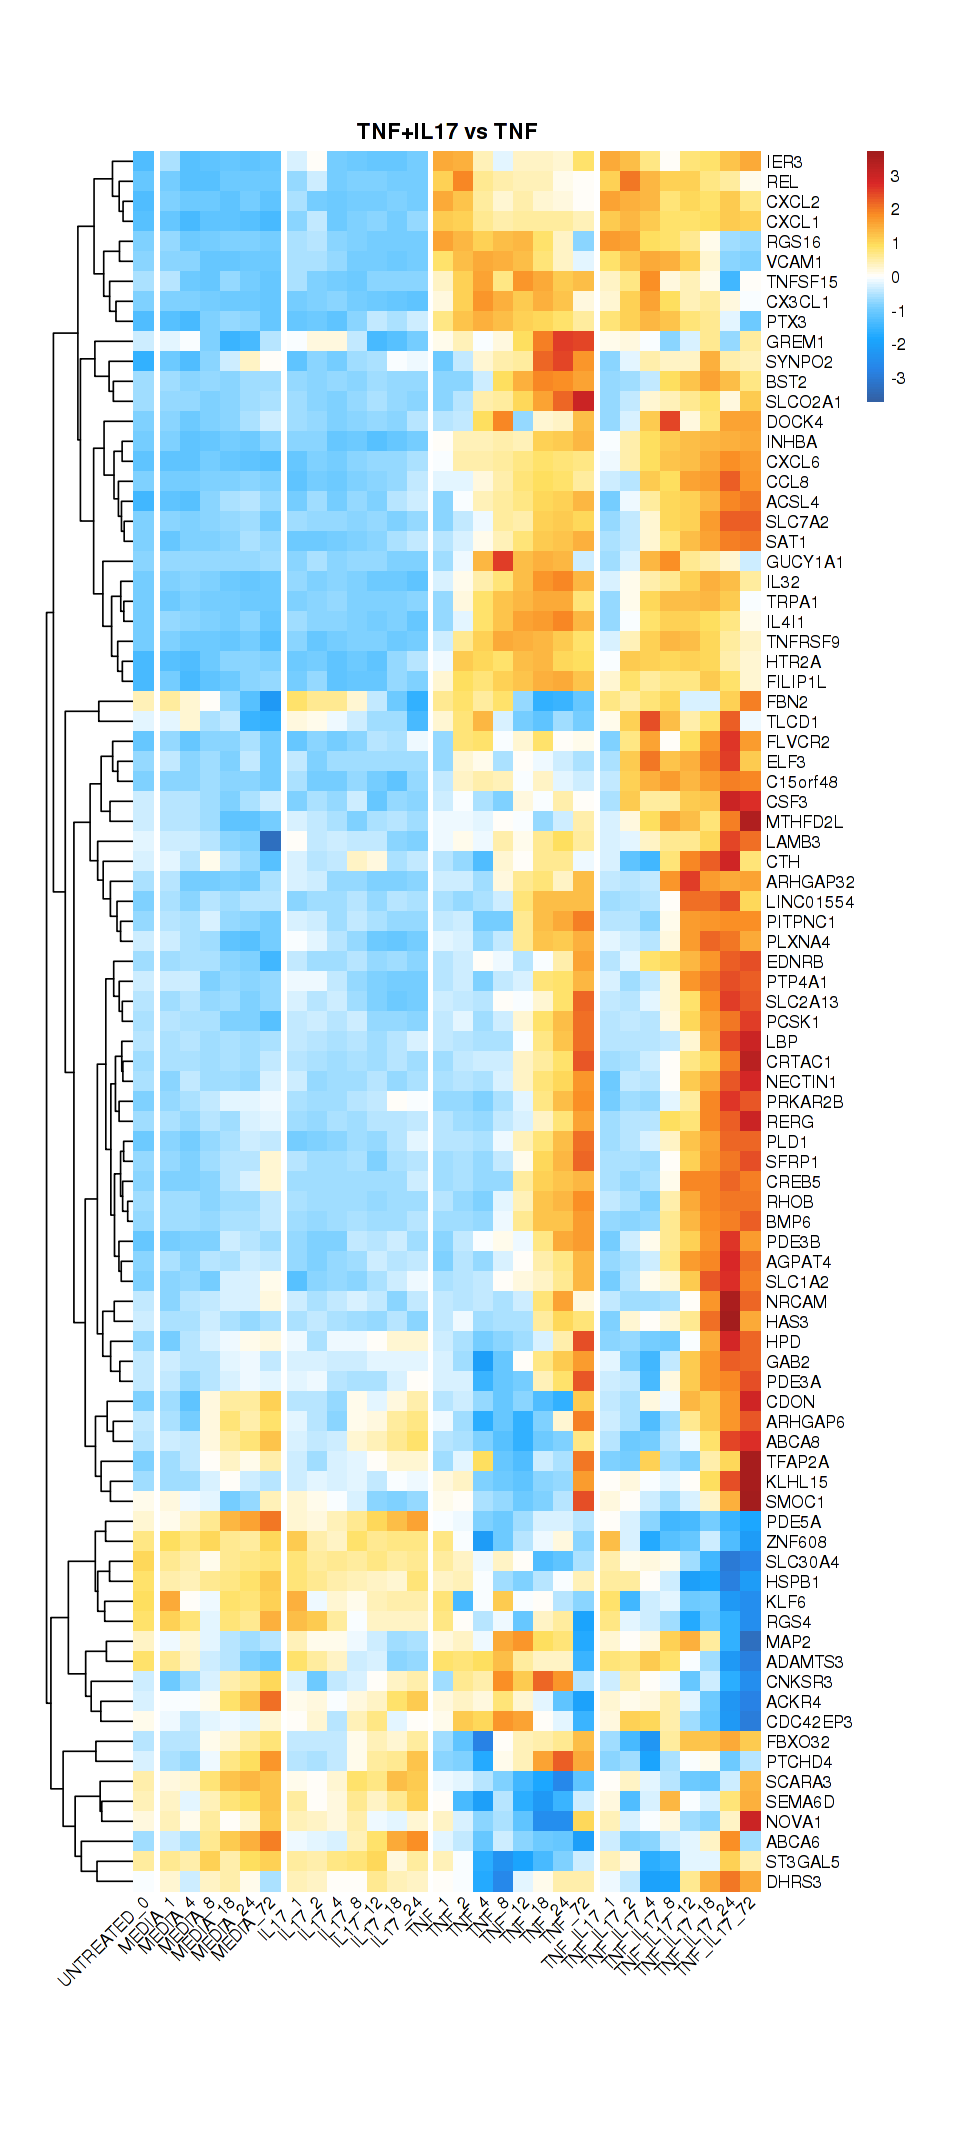

In [230]:
mat_best <- m_fit$coefficients[il17_time_genes,]
rownames(mat_best) <- ensembl_to_symbol[rownames(mat_best)]

mat_cols <- c(
  "UNTREATED_0",
  sprintf("MEDIA_%s", c(1, 4, 8, 18, 24, 72)),
  sprintf("IL17_%s", c(1, 2, 4, 8, 12, 18, 24)),
  sprintf("TNF_%s", c(1, 2, 4, 8, 12, 18, 24, 72)),
  sprintf("TNF_IL17_%s", c(1, 2, 4, 8, 12, 18, 24, 72))
)
mat_best <- mat_best[,mat_cols]

range(mat_best)

options(repr.plot.width = 8, repr.plot.height = nrow(mat_best) * 0.2 + 0.5)
pheatmap(
  mat = mat_best,
  scale = "row",
  #color = colorRampPalette(rev(brewer.pal(n = 7, name = "RdBu")))(100),
    #breaks = get_breaks(mat_time, 100),
  color = colorRampPalette(BuenColors::jdb_palettes$solar_flare)(100),
#   breaks = get_breaks(mat_best, 100),
#     color = quantile_breaks(mat_best, 50)$colors,
#     breaks = quantile_breaks(mat_best, 50)$breaks,
  cluster_cols = FALSE,
  cellwidth = 12,
  cellheight = 12,
  border_color = NA,
  gaps_col = c(1, 7, 14, 22),
  main = "TNF+IL17 vs TNF"
)

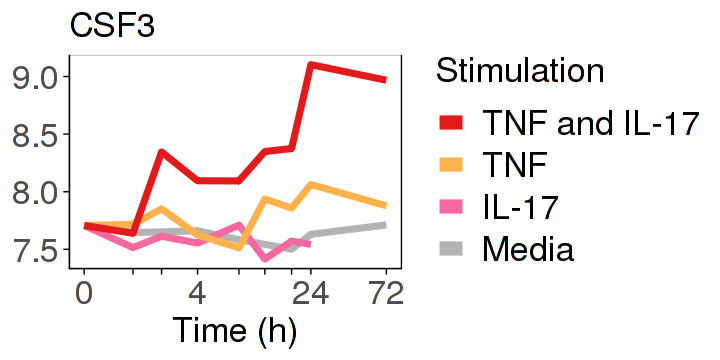

In [299]:
plot_gene <- function(gene) {
#   gene <- "CXCL2"

  if (gene %in% rownames(m_exp)) {
    ensembl_id  <- gene
    gene_symbol <- ensembl_to_symbol[ensembl_id]
  } else {
    ensembl_id  <- names(ensembl_to_symbol[which(ensembl_to_symbol == gene)])
    gene_symbol <- gene
  }
  m_meta$Gene <- as.numeric(m_exp[ensembl_id,])
  dat <- rbind.data.frame(
    m_meta[rep(which(m_meta$Time == "0"), 4),],
    m_meta[m_meta$Time != "0",]
  )
  dat$Time <- as.integer(dat$Time)
#   dat$Time[dat$Time == 72] <- 36
  rownames(dat) <- 1:nrow(dat)
  dat[1:8,]$Treatment <- dat[9:16,]$Treatment
  dat <- dat %>%
    group_by(Time, Treatment) %>%
    summarise(mean = mean(Gene))
  dat$Treatment <- relevel(dat$Treatment, ref = "MEDIA")
  p <- ggplot() +
  geom_line(
    data    = dat,
    mapping = aes(
#       x = factor(Time),
      x = Time,
      y = mean,
      group = Treatment,
      color = Treatment
    ),
    size = 1.5
  ) +
  scale_color_manual(
    guide = guide_legend(title = "Stimulation", override.aes = aes(size = 3), reverse = TRUE),
    values = meta_colors$Treatment,
    labels = c("Media", "IL-17", "TNF", "TNF and IL-17")
  ) +
  scale_x_continuous(
    trans = "log1p",
    breaks = c(0, 1, 2 , 4, 8, 12, 18, 24, 72),
    labels = c(0, "", "", 4, "", "", "", 24, 72)
  ) +
  scale_y_continuous(breaks = scales::pretty_breaks(4)) +
  labs(
    x = "Time (h)",
    y = NULL,
    title = gene
  ) +
  theme(legend.key.height = unit(1.75, "lines"),
    plot.title = element_text(face = "italic", size = 20),
    axis.title = element_text(size = 20),
    axis.text = element_text(size = 20),
    legend.title = element_text(size = 20),
    legend.text = element_text(size = 20),
    axis.ticks   = element_line(colour = "black", size = 0.3),
    panel.border = element_rect(size = 0.3, fill = NA),
    axis.line    = element_blank()
  )
  #show_plot(p)
  p
}
options(repr.plot.width = 6, repr.plot.height = 3)
# show_plot(plot_gene("CSF3"))
plot_gene("CSF3")

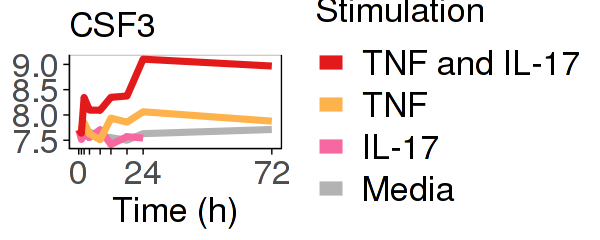

In [232]:
options(repr.plot.width = 5, repr.plot.height = 2)
plot_gene("CSF3")

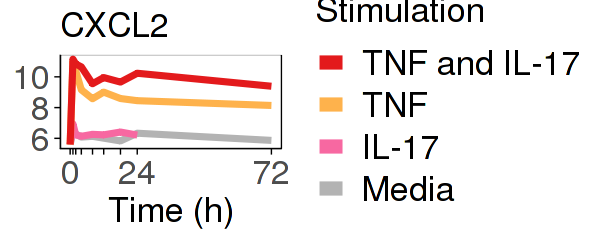

In [233]:
options(repr.plot.width = 5, repr.plot.height = 2)
plot_gene("CXCL2")

In [234]:
m_des2 <- with(
  m_meta,
  model.matrix(~ 0 + Treatment)
)
colnames(m_des2) <- str_replace_all(colnames(m_des2), "Treatment", "")
# colnames(m_des) <- str_replace_all(colnames(m_des), "Time", "T")

m_fit2 <- lmFit(object = m_exp, design = m_des2)
m_fit2 <- eBayes(m_fit2)

m_con2 <- makeContrasts(
  levels       = m_des2,
  IL17         = IL17 - MEDIA,
  TNF          = TNF - MEDIA,
  TNF_IL17     = TNF_IL17 - MEDIA,
  TNF_IL17_TNF = TNF_IL17 - TNF
)
m_con2 <- contrasts.fit(m_fit2, m_con2)
m_con2 <- eBayes(m_con2)

In [235]:
table(m_meta$Treatment, m_meta$Time)

           
            0 1 12 18 2 24 4 72 8
  IL17      0 2  2  2 2  2 2  0 2
  MEDIA     0 2  0  2 0  2 2  2 2
  TNF       0 2  2  2 2  2 2  2 2
  TNF_IL17  0 2  2  2 2  2 2  2 2
  UNTREATED 2 0  0  0 0  0 0  0 0

In [236]:
m_decide2 <- decideTests(m_con2, lfc = log2(1.5), p.value = 0.05)

do.call(rbind, apply(m_decide2, 2, function(x) {
  data.frame(
    "Up"        = sum(x == 1),
    "Down"      = sum(x == -1),
    "Unchanged" = sum(x == 0)
  )
}))

,Up,Down,Unchanged
IL17,3,0,17838
TNF,699,413,16729
TNF_IL17,724,486,16631
TNF_IL17_TNF,7,2,17832


Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.
Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.
Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.


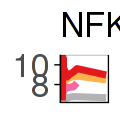

$ENSG00000144802

$ENSG00000163739

$ENSG00000169429


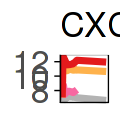

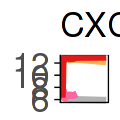

In [237]:
il17_genes <- ensembl_to_symbol[names(which((m_decide2 != 0)[,"IL17"]))]

plotlist <- lapply(il17_genes, function(gene) {
  plot_gene(gene) +
  labs(x = NULL, y = NULL) +
  theme(legend.position = "none", title = element_text(size = 8), axis.text.x = element_blank(), axis.ticks.x = element_blank()) +
  # scale_x_discrete(labels = c(0, '', '', '', '', '', '', '', 24)) +
  scale_y_continuous(breaks = pretty_breaks(n = 3))
})

# options(repr.plot.width = 6, repr.plot.height = ceiling(length(il17_genes) / 6))

# wrap_plots(plotlist, ncol = 6)

options(repr.plot.width = 1, repr.plot.height = 1)

plotlist

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.
Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.
Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.
Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.
Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.
Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.
Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.
Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.
Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.


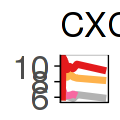

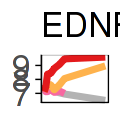

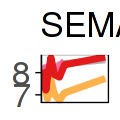

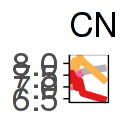

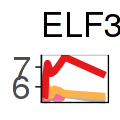

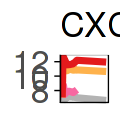

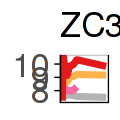

$ENSG00000081041

$ENSG00000136160

$ENSG00000137872

$ENSG00000153721

$ENSG00000163435

$ENSG00000163739

$ENSG00000163874

$ENSG00000166920

$ENSG00000181634


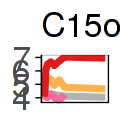

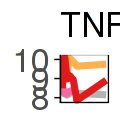

In [238]:
tnf_il17_genes <- ensembl_to_symbol[names(which((m_decide2 != 0)[,"TNF_IL17_TNF"]))]

plotlist <- lapply(tnf_il17_genes, function(gene) {
  plot_gene(gene) +
  labs(x = NULL, y = NULL) +
  theme(legend.position = "none", title = element_text(size = 8), axis.text.x = element_blank(), axis.ticks.x = element_blank()) +
  # scale_x_discrete(labels = c(0, '', '', '', '', '', '', '', 24)) +
  scale_y_continuous(breaks = pretty_breaks(n = 3))
})

# options(repr.plot.width = 6, repr.plot.height = ceiling(length(tnf_il17_genes) / 6))

# ggarrange(plots = plotlist, ncol = 6)

options(repr.plot.width = 1, repr.plot.height = 1)

plotlist

In [239]:
table(m_meta$Treatment, m_meta$Time)

           
            0 1 12 18 2 24 4 72 8
  IL17      0 2  2  2 2  2 2  0 2
  MEDIA     0 2  0  2 0  2 2  2 2
  TNF       0 2  2  2 2  2 2  2 2
  TNF_IL17  0 2  2  2 2  2 2  2 2
  UNTREATED 2 0  0  0 0  0 0  0 0

# BEST MODEL

## IL17 alone, TNF alone, and TNF+IL17

In [240]:
m_des3_ix <- which(m_meta$Time %in% c(1, 2, 4, 8, 12, 18, 24, 72))

m_meta3 <- m_meta[m_des3_ix,]
m_meta3$Treatment <- factor(m_meta3$Treatment)
m_meta3$Time <- factor(m_meta3$Time)
m_meta3$Treatment <- relevel(m_meta3$Treatment, ref = "MEDIA")

m_exp3 <- m_exp[,m_des3_ix]

m_des3 <- with(
  m_meta3,
  model.matrix(~ Time + Treatment)
)
colnames(m_des3) <- str_replace_all(colnames(m_des3), "\\(Intercept\\)", "Intercept")
colnames(m_des3) <- str_replace_all(colnames(m_des3), "Treatment", "")
colnames(m_des3) <- str_replace_all(colnames(m_des3), "Time", "T")

m_fit3 <- lmFit(object = m_exp3, design = m_des3)
m_fit3 <- eBayes(m_fit3)
m_fit3$genes <- ensembl_to_symbol[rownames(m_fit3$coefficients)]

m_con3 <- makeContrasts(
  levels       = m_des3,
  IL17         = IL17,
  TNF          = TNF,
  TNF_IL17_TNF = TNF_IL17 - TNF
)
m_con3 <- contrasts.fit(m_fit3, m_con3)
m_con3 <- eBayes(m_con3)

In [241]:
colnames(m_des3)

[1] "Intercept" "T12"       "T18"       "T2"        "T24"       "T4"       
 [7] "T72"       "T8"        "IL17"      "TNF"       "TNF_IL17"

In [242]:
m_con3_top <- rbindlist(lapply(c("IL17", "TNF", "TNF_IL17_TNF"), function(coef) {
  retval <- topTable(m_con3, confint = TRUE, coef = coef, number = nrow(m_con3$coefficients))
  retval$ensembl_id <- rownames(retval)
  retval$Coef <- coef
  retval
}))
m_con3_top$Coef[m_con3_top$Coef == "IL17"] <- "IL17_vs_MEDIA"
m_con3_top$Coef[m_con3_top$Coef == "TNF"] <- "TNF_vs_MEDIA"
m_con3_top$Coef[m_con3_top$Coef == "TNF_IL17_TNF"] <- "TNF_IL17_vs_TNF"
head(m_con3_top)

ID,logFC,CI.L,CI.R,AveExpr,t,P.Value,adj.P.Val,B,ensembl_id,Coef
NFKBIZ,0.9948799,0.7591688,1.2305909,8.373634,8.471101,2.449163e-11,4.369551e-07,10.745861,ENSG00000144802,IL17_vs_MEDIA
TNFAIP6,0.5771612,0.4213953,0.7329271,12.154793,7.436593,1.040782e-09,9.284296e-06,8.392759,ENSG00000123610,IL17_vs_MEDIA
CXCL1,0.8127774,0.5878142,1.0377405,9.764866,7.251193,2.048815e-09,1.218430e-05,7.955384,ENSG00000163739,IL17_vs_MEDIA
NFKBIA,0.2222564,0.1373628,0.3071499,11.220804,5.254469,2.858058e-06,1.274765e-02,3.070476,ENSG00000100906,IL17_vs_MEDIA
ZC3H12A,0.4466885,0.2632237,0.6301533,8.811489,4.886538,1.036983e-05,3.700163e-02,2.166737,ENSG00000163874,IL17_vs_MEDIA
IL6,0.9227625,0.5138699,1.3316550,11.265572,4.529288,3.526108e-05,9.665865e-02,1.301423,ENSG00000136244,IL17_vs_MEDIA


In [243]:
readr::write_tsv(
  x = format_numeric(as.data.frame(m_con3_top)),
  path = "analysis/limma/002_microarray-data-1_limma_contrasts.tsv.gz"
)

In [244]:
print(colnames(m_fit3$coefficients))

 [1] "Intercept" "T12"       "T18"       "T2"        "T24"       "T4"       
 [7] "T72"       "T8"        "IL17"      "TNF"       "TNF_IL17" 


Here we test TNF+IL17 versus TNF alone:

In [245]:
m_con3_decide <- decideTests(m_con3, lfc = log2(1.5), p.value = 0.05)
do.call(rbind, apply(m_con3_decide, 2, function(x) {
  data.frame(
    "Up"        = sum(x == 1),
    "Down"      = sum(x == -1),
    "Unchanged" = sum(x == 0),
    "Total"     = sum(x != 0)
  )
}))

,Up,Down,Unchanged,Total
IL17,2,0,17839,2
TNF,754,454,16633,1208
TNF_IL17_TNF,13,2,17826,15


In [246]:
library(ggrastr)

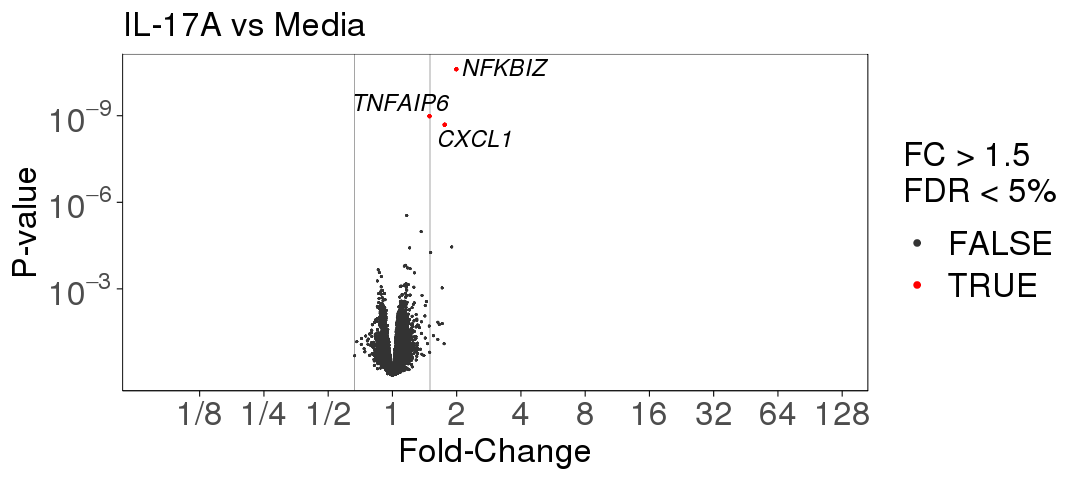

,ID,logFC,CI.L,CI.R,AveExpr,t,P.Value,adj.P.Val,B,sig,label,FC
ENSG00000144802,NFKBIZ,0.9948799,0.7591688,1.2305909,8.373634,8.471101,2.449163e-11,4.369551e-07,10.745861,TRUE,NFKBIZ,1.992915
ENSG00000123610,TNFAIP6,0.5771612,0.4213953,0.7329271,12.154793,7.436593,1.040782e-09,9.284296e-06,8.392759,TRUE,TNFAIP6,1.491911
ENSG00000163739,CXCL1,0.8127774,0.5878142,1.0377405,9.764866,7.251193,2.048815e-09,1.218430e-05,7.955384,TRUE,CXCL1,1.756590


In [286]:
d <- topTable(m_con3, coef = "IL17", confint = TRUE, number = 1e6)

d$sig <- with(d, adj.P.Val < 0.05 & abs(logFC) >= log2(1.49))
d$label <- d$ID
d$label[!d$sig] <- ""
d$FC <- 2^d$logFC


scientific_10 <- function(x) {
  parse(text=gsub("\\.+e", " %*% 10^", scales::scientific_format()(x)))
}

p <- ggplot(d) +
aes(x = 2^logFC, y = -log10(P.Value), color = sig, size = sig, label = label) +
geom_vline(xintercept = c(1.5, 1 / 1.5), size = 0.1) +
geom_point_rast() +
geom_text_repel(
  size = 5, box.padding = unit(0.2, "lines"), segment.size = 0.2,
  fontface = "italic", color = "black"
) +
scale_size_manual(values = c(0.5, 1), guide = FALSE) +
scale_color_manual(values = c("grey20", "red"), guide = guide_legend(title = "FC > 1.5\nFDR < 5%")) +
# scale_x_continuous(trans = "log2", breaks = c(1, 1.5, 2)) +
scale_x_continuous(
  limits = 2 ^ c(-3.2, 6.4),
  expand = c(0, 1),
  trans = "log2",
  labels = fractional::fractional,
  breaks = c(1/8, 1/4, 1/2, 1, 2, 4, 8, 16, 32, 64, 128)
) + #, breaks = c(1, 1.5, 2)) +
# scale_y_continuous(labels = function(x) scientific_10(10^-x), breaks = c(3, 6, 9)) +
scale_y_continuous(labels = function(x) parse(text = sprintf("10^-%s", x)), breaks = c(3, 6, 9)) +
# labs(x = bquote("Log"[2]~"FC"), y = bquote("-Log"[10]~"P"))
labs(x = "Fold-Change", y = "P-value", title = "IL-17A vs Media") +
theme(
  legend.key.height = unit(1.75, "lines"),
  plot.title = element_text(size = 20, hjust = 0),
  axis.title = element_text(size = 20),
  axis.text = element_text(size = 20),
  legend.title = element_text(size = 20),
  legend.text = element_text(size = 20),
  axis.ticks   = element_line(colour = "black", size = 0.3),
  panel.border = element_rect(size = 0.3, fill = NA),
  axis.line    = element_blank()
)

options(repr.plot.width = 9, repr.plot.height = 4)
show_plot(p, name = "microarray-data-1-IL17-volcano")
                   
d[d$sig,]

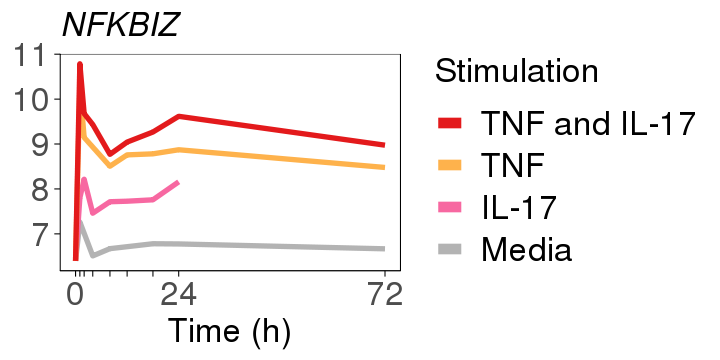

In [287]:
options(repr.plot.width = 6, repr.plot.height = 3)
show_plot(plot_gene(gene = "NFKBIZ"), name = "microarray-data-1-NFKBIZ")

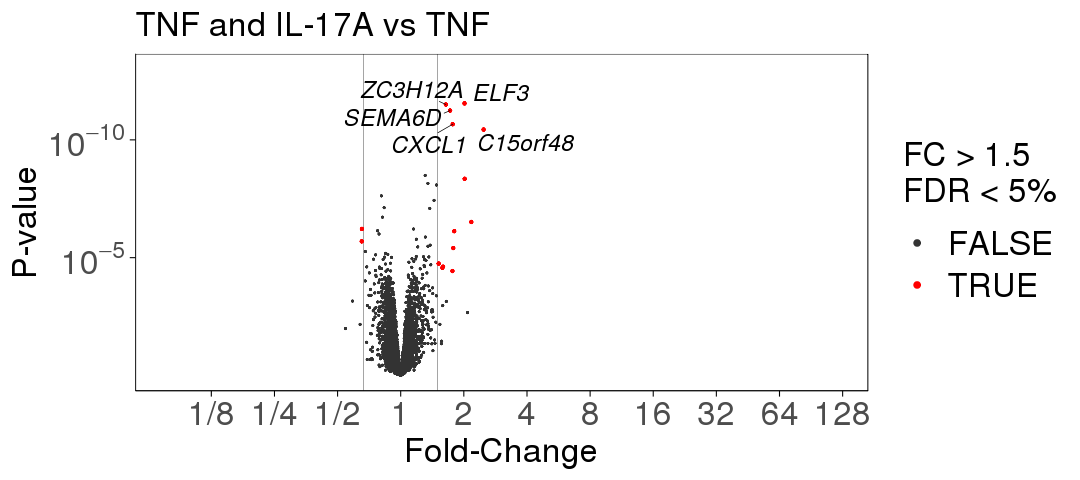

,ID,logFC,CI.L,CI.R,AveExpr,t,P.Value,adj.P.Val,B,sig,label,wt,FC
ENSG00000163435,ELF3,1.0107619,0.7872679,1.2342558,5.900354,9.076792,2.828318e-12,2.803410e-08,16.89801,TRUE,ELF3,12.55923,2.014975
ENSG00000163874,ZC3H12A,0.7143100,0.5558457,0.8727743,8.811489,9.046999,3.142661e-12,2.803410e-08,16.80525,TRUE,ZC3H12A,12.21701,1.640698
ENSG00000137872,SEMA6D,0.7829190,0.6059695,0.9598685,7.912276,8.880077,5.680926e-12,3.378447e-08,16.28338,TRUE,SEMA6D,12.02850,1.720609
ENSG00000163739,CXCL1,0.8235054,0.6291977,1.0178131,9.764866,8.506005,2.160816e-11,9.637778e-08,15.10126,TRUE,CXCL1,11.48889,1.769701
ENSG00000166920,C15orf48,1.3126692,0.9975868,1.6277516,5.002815,8.361427,3.632663e-11,1.296207e-07,14.63999,TRUE,C15orf48,11.75244,2.484007


In [288]:
d <- topTable(m_con3, coef = "TNF_IL17_TNF", confint = TRUE, number = 1e6)

d$sig <- with(d, adj.P.Val < 0.05 & abs(logFC) >= log2(1.5))
d$label <- ""
d$wt <- -log10(d$P.Value) + d$logFC
ix <- d$wt >= sort(d$wt, decreasing = TRUE)[5]
d$label[ix] <- d$ID[ix]
d$FC <- 2^d$logFC

scientific_10 <- function(x) {
  parse(text=gsub("\\.+e", " %*% 10^", scales::scientific_format()(x)))
}

pow10 <- function(x) {
  ifelse(
    x > 1,
    parse(text = sprintf("10^-%s", x)),
    1
  )
}

p <- ggplot(d) +
aes(x = 2^logFC, y = -log10(P.Value), color = sig, size = sig, label = label) +
geom_vline(xintercept = c(1.5, 1 / 1.5), size = 0.1) +
geom_point_rast() +
geom_text_repel(
  size = 5, box.padding = unit(0.2, "lines"), segment.size = 0.2, min.segment.length = 0.2,
  fontface = "italic", color = "black", nudge_y = 0
) +
scale_size_manual(values = c(0.5, 1), guide = FALSE) +
scale_color_manual(values = c("grey20", "red"), guide = guide_legend(title = "FC > 1.5\nFDR < 5%")) +
# scale_x_continuous(limits = c(1.6/3, 3), trans = "log2", breaks = c(1 / 1.5, 1, 1.5, 2, 4), labels = fractional::fractional) +
scale_x_continuous(
  limits = 2 ^ c(-3.2, 6.4),
  expand = c(0, 1),
  trans = "log2",
  labels = fractional::fractional,
  breaks = c(1/8, 1/4, 1/2, 1, 2, 4, 8, 16, 32, 64, 128)
) + #, breaks = c(1, 1.5, 2)) +
# scale_y_continuous(labels = function(x) scientific_10(10^-x), breaks = c(3, 6, 9)) +
scale_y_continuous(limits = -log10(c(1, 1e-13)), labels = pow10, breaks = c(5, 10)) +#+, breaks = c(3, 6, 9)) +
# labs(x = bquote("Log"[2]~"FC"), y = bquote("-Log"[10]~"P"))
labs(x = "Fold-Change", y = "P-value", title = "TNF and IL-17A vs TNF") +
theme(
  legend.key.height = unit(1.75, "lines"),
  plot.title = element_text(size = 20, hjust = 0),
  axis.title = element_text(size = 20),
  axis.text = element_text(size = 20),
  legend.title = element_text(size = 20),
  legend.text = element_text(size = 20),
  axis.ticks   = element_line(colour = "black", size = 0.3),
  panel.border = element_rect(size = 0.3, fill = NA),
  axis.line    = element_blank()
)

options(repr.plot.width = 9, repr.plot.height = 4)
show_plot(p, name = "microarray-data-1-TNF-and-IL17-volcano")
                   
head(subset(d, label != ""))

In [289]:
top <- topTable(m_con3, coef = "IL17", confint = TRUE)
top %>%
mutate(Gene = ID, FC = signif(2^logFC, 2), MeanExpr = signif(AveExpr, 2), P = signif(P.Value, 1), FDR = signif(adj.P.Val, 1)) %>%
dplyr::select(Gene, MeanExpr, FC, P, FDR)

Gene,MeanExpr,FC,P,FDR
NFKBIZ,8.4,2.0,2e-11,4e-07
TNFAIP6,12.0,1.5,1e-09,9e-06
CXCL1,9.8,1.8,2e-09,1e-05
NFKBIA,11.0,1.2,3e-06,1e-02
ZC3H12A,8.8,1.4,1e-05,4e-02
IL6,11.0,1.9,4e-05,1e-01
BORA,6.0,1.2,4e-05,1e-01
CXCL8,9.9,1.5,5e-05,1e-01
DCTN6,9.1,1.2,2e-04,3e-01
RBP4,9.4,1.1,2e-04,3e-01


In [290]:
top <- topTable(m_con3, coef = "TNF_IL17_TNF", confint = TRUE)
top %>%
mutate(Gene = ID, FC = signif(2^logFC, 2), MeanExpr = signif(AveExpr, 2), P = signif(P.Value, 1), FDR = signif(adj.P.Val, 1)) %>%
dplyr::select(Gene, MeanExpr, FC, P, FDR)

Gene,MeanExpr,FC,P,FDR
ELF3,5.9,2.00,3e-12,3e-08
ZC3H12A,8.8,1.60,3e-12,3e-08
SEMA6D,7.9,1.70,6e-12,3e-08
CXCL1,9.8,1.80,2e-11,1e-07
C15orf48,5.0,2.50,4e-11,1e-07
SLC43A3,11.0,1.30,3e-09,1e-05
CXCL2,8.1,2.00,4e-09,1e-05
CDON,9.7,1.30,7e-09,2e-05
CSF3,7.9,1.50,8e-09,2e-05
CACNB1,8.6,0.81,2e-08,4e-05


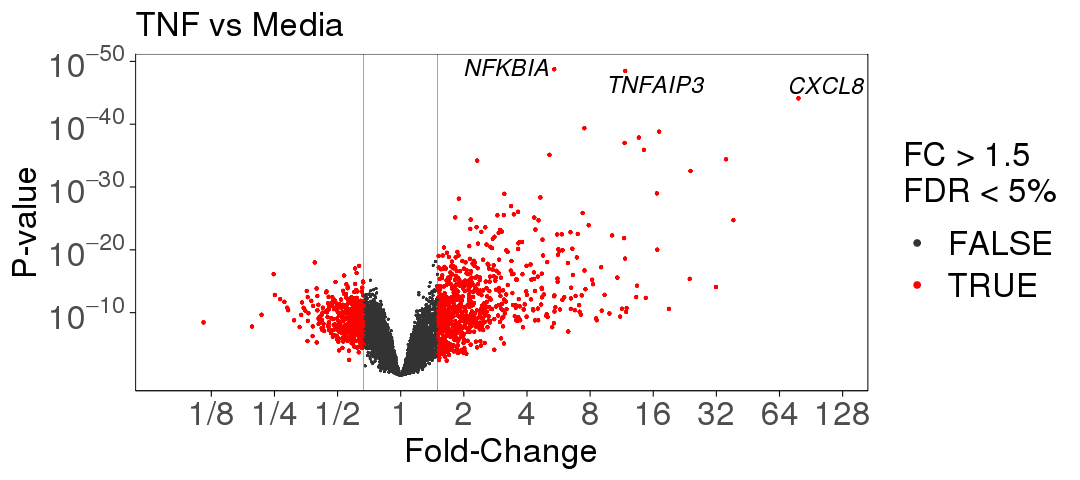

,ID,logFC,CI.L,CI.R,AveExpr,t,P.Value,adj.P.Val,B,sig,label,FC
ENSG00000100906,NFKBIA,2.431993,2.350890,2.513096,11.220804,60.18293,1.765999e-49,2.977281e-45,98.14079,TRUE,NFKBIA,5.396385
ENSG00000118503,TNFAIP3,3.555919,3.435842,3.675996,9.994382,59.43484,3.337571e-49,2.977281e-45,97.63895,TRUE,TNFAIP3,11.760841
ENSG00000169429,CXCL8,6.300428,6.041078,6.559777,9.909465,48.75668,7.682083e-45,4.568535e-41,89.37712,TRUE,CXCL8,78.816596
ENSG00000123610,TNFAIP6,2.908676,2.759865,3.057487,12.154793,39.22912,4.286764e-40,1.912004e-36,79.77206,TRUE,,7.509288
ENSG00000163739,CXCL1,4.093739,3.878819,4.308658,9.764866,38.22912,1.555938e-39,5.551897e-36,78.60483,TRUE,,17.074111
ENSG00000023445,BIRC3,3.771067,3.564322,3.977812,9.474388,36.60821,1.346348e-38,4.003366e-35,76.63696,TRUE,,13.652253


In [291]:
d <- topTable(m_con3, coef = "TNF", confint = TRUE, number = 1e6)

d$sig <- with(d, adj.P.Val < 0.05 & abs(logFC) >= log2(1.5))
d$label <- ""
ix <- d$P.Value <= sort(d$P.Value)[3]
d$label[ix] <- d$ID[ix]
d$FC <- 2^d$logFC


scientific_10 <- function(x) {
  parse(text=gsub("\\.+e", " %*% 10^", scales::scientific_format()(x)))
}

p <- ggplot(d) +
aes(x = 2^logFC, y = -log10(P.Value), color = sig, size = sig, label = label) +
geom_vline(xintercept = c(1.5, 1 / 1.5), size = 0.1) +
geom_point_rast() +
geom_text_repel(
  size = 5, box.padding = unit(0.2, "lines"), segment.size = 0.2,
  fontface = "italic", color = "black"
) +
scale_size_manual(values = c(0.5, 1), guide = FALSE) +
scale_color_manual(values = c("grey20", "red"), guide = guide_legend(title = "FC > 1.5\nFDR < 5%")) +
scale_x_continuous(
  limits = 2 ^ c(-3.2, 6.4),
  expand = c(0, 1),
  trans = "log2",
  labels = fractional::fractional,
  breaks = c(1/8, 1/4, 1/2, 1, 2, 4, 8, 16, 32, 64, 128)
) + #, breaks = c(1, 1.5, 2)) +
# scale_y_continuous(labels = function(x) scientific_10(10^-x), breaks = c(3, 6, 9)) +
scale_y_continuous(labels = function(x) parse(text = sprintf("10^-%s", x)), breaks = c(10, 20, 30, 40, 50)) +
# labs(x = bquote("Log"[2]~"FC"), y = bquote("-Log"[10]~"P"))
labs(x = "Fold-Change", y = "P-value", title = "TNF vs Media") +
theme(
  legend.key.height = unit(1.75, "lines"),
  plot.title = element_text(size = 20, hjust = 0),
  axis.title = element_text(size = 20),
  axis.text = element_text(size = 20),
  legend.title = element_text(size = 20),
  legend.text = element_text(size = 20),
  axis.ticks   = element_line(colour = "black", size = 0.3),
  panel.border = element_rect(size = 0.3, fill = NA),
  axis.line    = element_blank()
)

options(repr.plot.width = 9, repr.plot.height = 4)

show_plot(p, name = "microarray-data-1-TNF-volcano")
                   
head(d[d$sig,])

In [253]:
range(d$logFC)

[1] -3.123367  6.300428

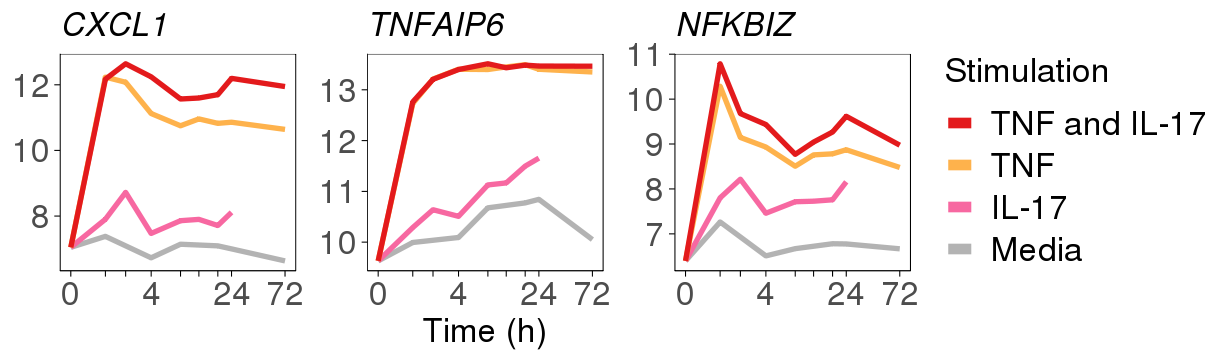

In [302]:
plotlist <- list(
  plot_gene("CXCL1") + theme(legend.position = "none", axis.title.x = element_blank()),
  plot_gene("TNFAIP6") + theme(legend.position = "none", axis.title.y = element_blank()),
  plot_gene("NFKBIZ") + theme(axis.title.y = element_blank(), axis.title.x = element_blank())
)

options(repr.plot.width = length(plotlist) * 3.25 + 0.5, repr.plot.height = 3)

show_plot(name = "microarray-data-1-IL17", patchwork::wrap_plots(plotlist,  ncol = length(plotlist)))

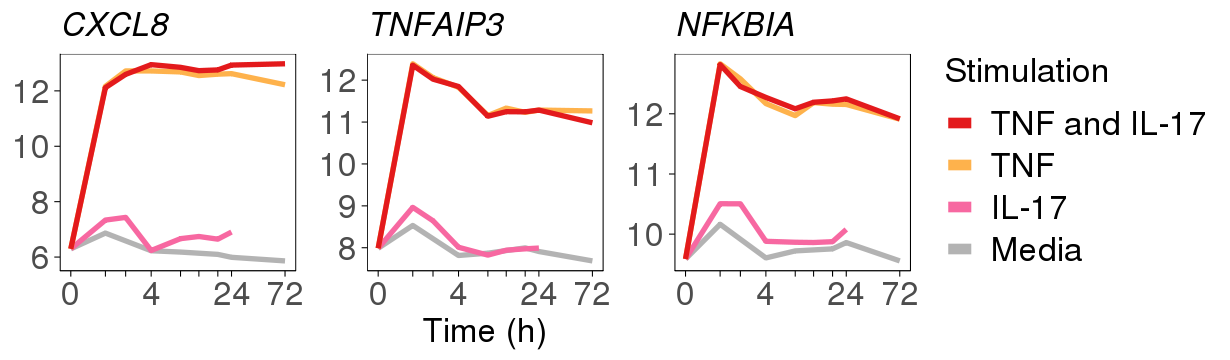

In [303]:
plotlist <- list(
  plot_gene("CXCL8") + theme(legend.position = "none", axis.title.x = element_blank()),
  plot_gene("TNFAIP3") + theme(legend.position = "none", axis.title.y = element_blank()),
  plot_gene("NFKBIA") + theme(axis.title.y = element_blank(), axis.title.x = element_blank())
)

options(repr.plot.width = length(plotlist) * 3.25 + 0.5, repr.plot.height = 3)

show_plot(name = "microarray-data-1-TNF", patchwork::wrap_plots(plotlist,  ncol = length(plotlist)))

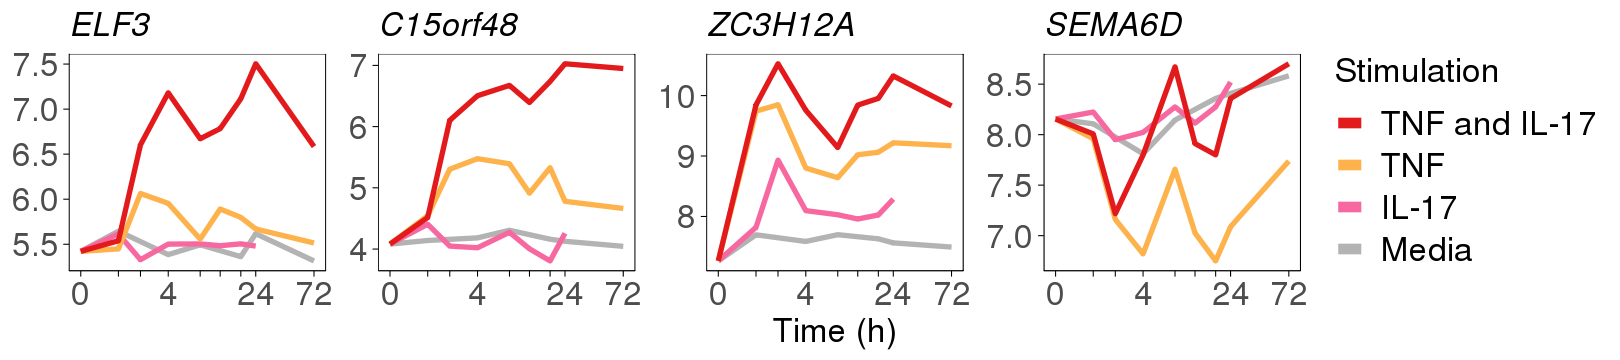

In [305]:
plotlist <- list(
  plot_gene("ELF3") + theme(legend.position = "none", axis.title.x = element_blank()),
  plot_gene("C15orf48") + theme(legend.position = "none", axis.title.x = element_blank(), axis.title.y = element_blank()),
  plot_gene("ZC3H12A") + theme(legend.position = "none", axis.title.y = element_blank()),
#   plot_gene("CXCL1") + theme(legend.position = "none", axis.title.x = element_blank(), axis.title.y = element_blank()),
  plot_gene("SEMA6D") + theme(axis.title.y = element_blank(), axis.title.x = element_blank())
)

options(repr.plot.width = length(plotlist) * 3.25 + 0.5, repr.plot.height = 3)

show_plot(name = "microarray-data-1-TNF-and-IL17", patchwork::wrap_plots(plotlist,  ncol = length(plotlist)))

Here we look at the effect of IL-17 alone, TNF alone, or TNF and IL-17:

In [257]:
# 2 fold-change
# 5% false discovery rate
m_decide3 <- decideTests(m_fit3, lfc = log2(1.5), p.value = 0.05)

do.call(rbind, apply(m_decide3, 2, function(x) {
  data.frame(
    "Up"        = sum(x == 1),
    "Down"      = sum(x == -1),
    "Unchanged" = sum(x == 0)
  )
}))

,Up,Down,Unchanged
Intercept,17841,0,0
T12,472,288,17081
T18,580,365,16896
T2,39,18,17784
T24,593,521,16727
T4,138,109,17594
T72,654,755,16432
T8,377,197,17267
IL17,2,0,17839
TNF,754,454,16633


# Export differential expression results

In [258]:
print(colnames(m_des3))

 [1] "Intercept" "T12"       "T18"       "T2"        "T24"       "T4"       
 [7] "T72"       "T8"        "IL17"      "TNF"       "TNF_IL17" 


In [259]:
m_fit3_top <- rbindlist(lapply(colnames(m_des3), function(coef) {
  retval <- topTable(m_fit3, confint = TRUE, coef = coef, number = nrow(m_fit3$coefficients))
  retval$ensembl_id <- rownames(retval)
  retval$Coef <- coef
  retval
}))
head(m_fit3_top)

ID,logFC,CI.L,CI.R,AveExpr,t,P.Value,adj.P.Val,B,ensembl_id,Coef
MFGE8,12.37972,12.33353,12.42590,12.31610,537.9793,2.019756e-98,1.899804e-94,198.7417,ENSG00000140545,Intercept
GAPDH,13.19553,13.14625,13.24481,13.20680,537.4270,2.129706e-98,1.899804e-94,198.7159,ENSG00000111640,Intercept
SPARC,13.22585,13.17572,13.27598,13.18159,529.5446,4.564918e-98,2.714757e-94,198.3418,ENSG00000113140,Intercept
UBC,13.22710,13.17424,13.27995,13.19848,502.2291,7.018571e-97,3.130458e-93,196.9537,ENSG00000150991,Intercept
APP,12.16275,12.11323,12.21227,12.15099,492.9457,1.837975e-96,6.558263e-93,196.4471,ENSG00000142192,Intercept
TIMP1,13.33532,13.28073,13.38992,13.35141,490.2075,2.449986e-96,7.285033e-93,196.2941,ENSG00000102265,Intercept


In [260]:
getwd()

readr::write_tsv(
  x = format_numeric(as.data.frame(m_fit3_top)),
  path = "analysis/limma/002_microarrays_limma_timefactor_stimfactor.tsv.gz"
)

[1] "/data/srlab/slowikow/fibroblast_timecourse"

In [261]:
2 + 0

752 + 451

766 + 515

[1] 2

[1] 1203

[1] 1281

In [262]:
top <- topTable(m_fit3, coef = "IL17", confint = TRUE)
top$FC <- signif(2^top$logFC, 2)
top

il17_genes <- rownames(top)

,ID,logFC,CI.L,CI.R,AveExpr,t,P.Value,adj.P.Val,B,FC
ENSG00000144802,NFKBIZ,0.9948799,0.75916877,1.2305909,8.373634,8.471101,2.449163e-11,4.369551e-07,10.7458611,2.0
ENSG00000123610,TNFAIP6,0.5771612,0.42139533,0.7329271,12.154793,7.436593,1.040782e-09,9.284296e-06,8.3927592,1.5
ENSG00000163739,CXCL1,0.8127774,0.58781420,1.0377405,9.764866,7.251193,2.048815e-09,1.218430e-05,7.9553836,1.8
ENSG00000100906,NFKBIA,0.2222564,0.13736282,0.3071499,11.220804,5.254469,2.858058e-06,1.274765e-02,3.0704758,1.2
ENSG00000163874,ZC3H12A,0.4466885,0.26322373,0.6301533,8.811489,4.886538,1.036983e-05,3.700163e-02,2.1667371,1.4
ENSG00000136244,IL6,0.9227625,0.51386993,1.3316550,11.265572,4.529288,3.526108e-05,9.665865e-02,1.3014234,1.9
ENSG00000136122,BORA,0.2682451,0.14881267,0.3876776,5.959237,4.507738,3.792447e-05,9.665865e-02,1.2497537,1.2
ENSG00000169429,CXCL8,0.5947825,0.32331271,0.8662523,9.909465,4.397298,5.497024e-05,1.225905e-01,0.9860748,1.5
ENSG00000104671,DCTN6,0.2053886,0.10455910,0.3062181,9.132787,4.088255,1.523864e-04,2.890032e-01,0.2596962,1.2
ENSG00000138207,RBP4,0.1852866,0.09390499,0.2766682,9.421773,4.069438,1.619882e-04,2.890032e-01,0.2160873,1.1


In [263]:
geneset <- il17_genes

coefs <- c(
  "T2", "T4", "T8", "T12", "T18", "T24", "T72",
  "IL17", "TNF", "TNF_IL17"
)

get_top <- function(fit, coefs, geneset, lfc = log2(1.5), p.value = 0.05) {
  retval <- data.table::rbindlist(lapply(coefs, function(this_coef) {
    retval <- topTable(
      fit     = fit,
      coef    = this_coef,
      number  = nrow(fit$coefficients),
      confint = TRUE
    )[geneset,]
    retval$coef      <- this_coef
    retval$signif    <- abs(retval$logFC) >= lfc & retval$adj.P.Val < p.value
    retval$ensembl   <- rownames(retval)
    rownames(retval) <- 1:nrow(retval)
    return(retval)
  }))
  retval$coef <- factor(retval$coef, coefs)
  return(retval)
}

geneset_dat <- get_top(m_fit3, coefs, geneset)

In [264]:
head(geneset_dat)
print(length(unique(geneset_dat$ID)))

ID,logFC,CI.L,CI.R,AveExpr,t,P.Value,adj.P.Val,B,coef,signif,ensembl
NFKBIZ,-0.5076080,-0.8223568,-0.192859236,8.373634,-3.236784,2.113936e-03,0.0894770826,-1.5620239,T2,FALSE,ENSG00000144802
TNFAIP6,0.3733369,0.1653402,0.581333551,12.154793,3.602415,7.085113e-04,0.0432895573,-0.5727784,T2,FALSE,ENSG00000123610
CXCL1,0.4054318,0.1050349,0.705828667,9.764866,2.708766,9.140730e-03,0.1936814364,-2.8647119,T2,FALSE,ENSG00000163739
NFKBIA,-0.1594508,-0.2728105,-0.046091094,11.220804,-2.823041,6.741993e-03,0.1668617858,-2.5966579,T2,FALSE,ENSG00000100906
ZC3H12A,0.6486795,0.4036960,0.893662954,8.811489,5.314258,2.312806e-06,0.0007916714,4.7079506,T2,TRUE,ENSG00000163874
IL6,-0.5435685,-1.0895692,0.002432255,11.265572,-1.998068,5.099160e-02,0.4667732760,-4.3350525,T2,FALSE,ENSG00000136244


[1] 10


### Fold-change and confidence interval

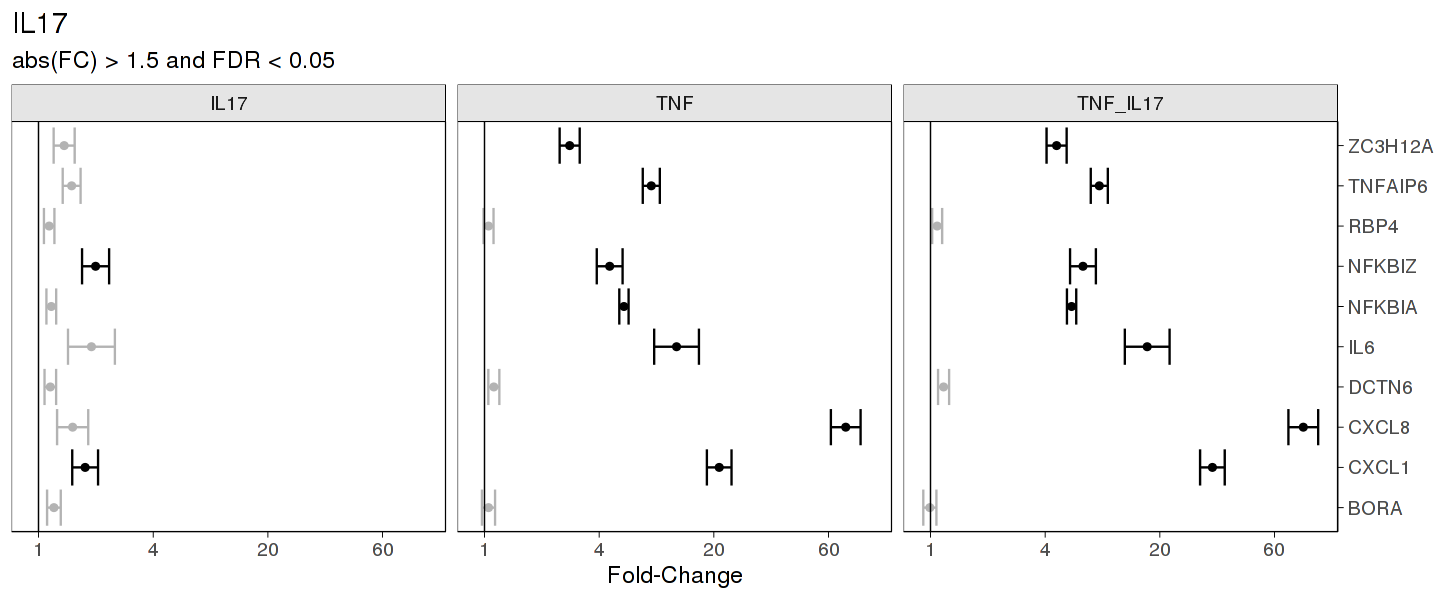

In [265]:
options(repr.plot.width = 12, repr.plot.height = nrow(geneset_dat) * 0.05)

geneset_dat %>% filter(coef %in% c("IL17", "TNF", "TNF_IL17")) %>%
ggplot(aes(x = ID, y = logFC, ymin = CI.L, ymax = CI.R, color = signif)) +
geom_errorbar() +
geom_point() +
scale_color_manual(values = c('grey70', 'black')) +
geom_hline(yintercept = 0, size = 0.3) +
scale_x_discrete(position = "top") +
scale_y_continuous(labels = function(x) signif(2^abs(x), 1)) +
coord_flip() +
facet_wrap(~ coef, ncol = 7) +
# theme_bw(base_size = 18) +
theme(strip.background = element_rect(fill = "grey90"), panel.border = element_rect(fill = NA, size = 0.25)) +
labs(x = NULL, y = "Fold-Change", title = "IL17", subtitle = "abs(FC) > 1.5 and FDR < 0.05") +
theme(legend.position = "none")

### Volcano

In [266]:
dat <- rbindlist(lapply(coefs, function(coef) {
  retval         <- topTable(m_fit3, coef = coef, number = nrow(m_fit3$coefficients))
  retval         <- retval[names(which(m_decide3[,coef] != 0)),]
  retval$Gene    <- ensembl_to_symbol[rownames(retval)]
  retval$Ensembl <- rownames(retval)
  retval$log10p  <- -log10(retval$P.Value)
  retval$coef    <- coef
  rownames(retval) <- seq(nrow(retval))
  return(retval)
}))
dat$coef <- factor(dat$coef, levels = coefs)
dat_label <- dat %>% group_by(coef) %>% summarise(nup = sum(logFC > 0), ndown = sum(logFC < 0))

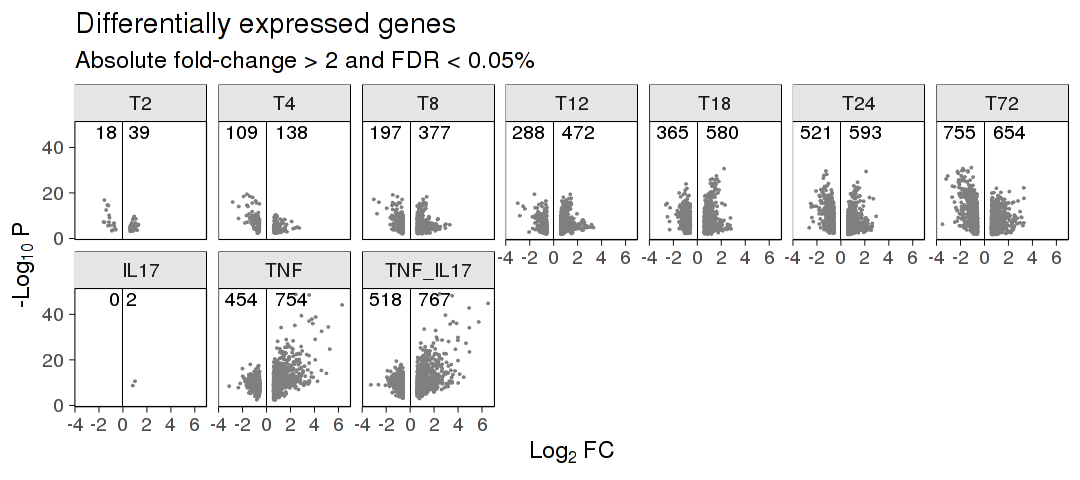

In [267]:
options(repr.plot.width = 9, repr.plot.height = 4)

ggplot() +
geom_vline(xintercept = 0, size = 0.2) +
geom_point(data = dat, mapping = aes(logFC, log10p), size = 0.01, color = 'grey50') +
geom_text(data = dat_label, mapping = aes(0, Inf, label = ndown), size = 4, hjust = 1.25, vjust = 1.25) +
geom_text(data = dat_label, mapping = aes(0, Inf, label = nup), size = 4, hjust = -0.25, vjust = 1.25) +
scale_y_continuous(breaks = pretty_breaks(3)) +
#scale_x_continuous(breaks = c(-6, -3, 0, 3, 6)) +# breaks = pretty_breaks(6)) +
theme(strip.background = element_rect(fill = "grey90"), panel.border = element_rect(fill = NA, size = 0.25)) +
facet_wrap(~ coef, ncol = 7) +
labs(
  x = bquote("Log"[2]~"FC"),
  y = bquote("-Log"[10]~"P"),
  title = "Differentially expressed genes",
  subtitle = "Absolute fold-change > 2 and FDR < 0.05%"
)

In [268]:
head(dat)

ID,logFC,AveExpr,t,P.Value,adj.P.Val,B,Gene,Ensembl,log10p,coef
HIVEP2,1.0654724,9.633596,7.235111,2.172870e-09,3.876618e-06,11.180823,HIVEP2,ENSG00000010818,8.662966,T2
SAMD4A,0.9020672,8.368108,7.590989,5.926154e-10,1.394276e-06,12.382100,SAMD4A,ENSG00000020577,9.227227,T2
KLF6,-0.7356164,8.162083,-6.049338,1.649917e-07,1.051292e-04,7.162433,KLF6,ENSG00000067082,6.782538,T2
PPP1R15A,-1.0789608,8.693987,-5.378124,1.843615e-06,6.998285e-04,4.918619,PPP1R15A,ENSG00000087074,5.734330,T2
ICAM1,0.6203429,10.724179,4.403780,5.379073e-05,7.497503e-03,1.792051,ICAM1,ENSG00000090339,4.269293,T2
HIVEP1,0.9341949,9.504100,7.862872,2.203726e-10,6.552780e-07,13.294759,HIVEP1,ENSG00000095951,9.656842,T2


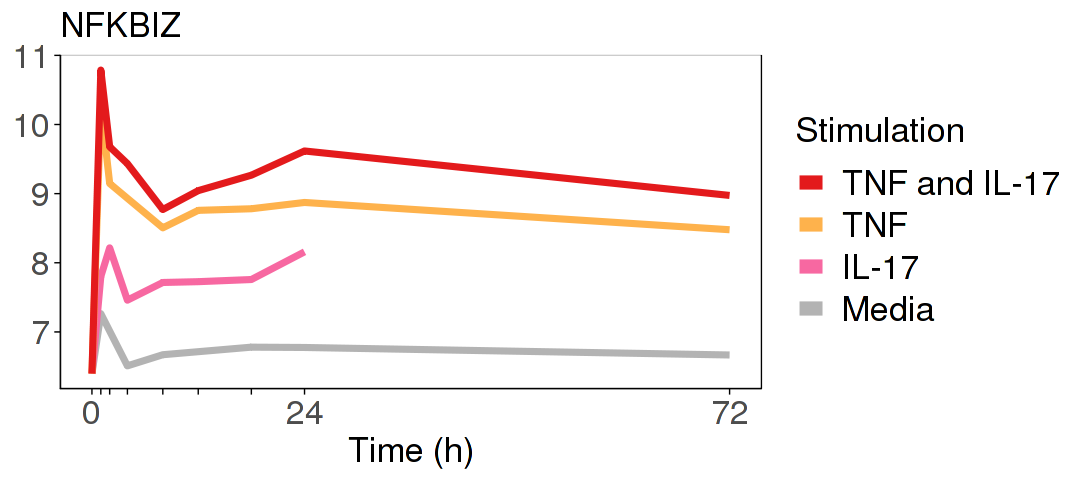

In [269]:
plot_gene("NFKBIZ")

In [271]:
options(repr.plot.width = 9, repr.plot.height = 4)

my_genes <- c("CXCL1", "CXCL2", "CXCL3", "CXCL6", "CXCL8", "IL6")
plotlist <- lapply(my_genes, function(my_gene) {
  plot_gene(my_gene) +
  theme_classic(base_size = 18) +
  theme(legend.position = "none") +
  labs(x = NULL, y = NULL)
})
# ggarrange(plots = plotlist, ncol = 3)

In [ ]:
table(meta$Time, meta$Treatment)

## PCA

In [272]:
library(matrixStats)

In [292]:
dim(m_exp)

[1] 17841    60

In [306]:

colnames(meta)

[1] "Time"           "Treatment"      "Replicate"      "common_percent"
[5] "Sample"

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10
Standard deviation,28.70524,15.24831,10.90676,7.16780,6.865646,6.435335,5.049144,4.490991,3.810901,3.661962
Proportion of Variance,0.52112,0.14705,0.07523,0.03249,0.029810,0.026190,0.016120,0.012760,0.009180,0.008480
Cumulative Proportion,0.52112,0.66816,0.74340,0.77589,0.805700,0.831890,0.848010,0.860770,0.869950,0.878430


,PC1,PC2,PC3,PC4,PC5
ENSG00000000003,-0.0056058118,-0.0083921832,-0.0050220065,-0.011540630,0.004481429
ENSG00000000005,-0.0003563357,0.0013169947,-0.0013681054,0.004639703,0.002423579
ENSG00000000419,0.0014644763,0.0002847921,0.0002714748,-0.007651376,-0.002829185
ENSG00000000457,0.0006762035,-0.0024483817,0.0036165320,-0.007898605,0.001190529
ENSG00000000460,-0.0018171403,0.0155573991,0.0109251406,0.002390366,-0.008358220


[1] 17841

term,estimate,std.error,statistic,p.value,pc,log10p,zscore
(Intercept),-32.915104,4.7456373,-6.9358659,5.236694e-09,1,8.2809428,5.8394707
Time,0.369639,0.0973115,3.7985127,3.711465e-04,1,3.4304546,3.5597935
TreatmentUNTREATED,4.879227,11.4974712,0.4243739,6.729791e-01,1,0.1719984,0.4220629
TreatmentIL17,4.210880,5.9293269,0.7101784,4.806493e-01,1,0.3181716,0.7052586
TreatmentTNF,47.699551,5.6662235,8.4182263,2.096985e-11,1,10.6784047,6.6991057
TreatmentTNF_IL17,49.351737,5.6662235,8.7098112,7.175037e-12,1,11.1441758,6.8541271


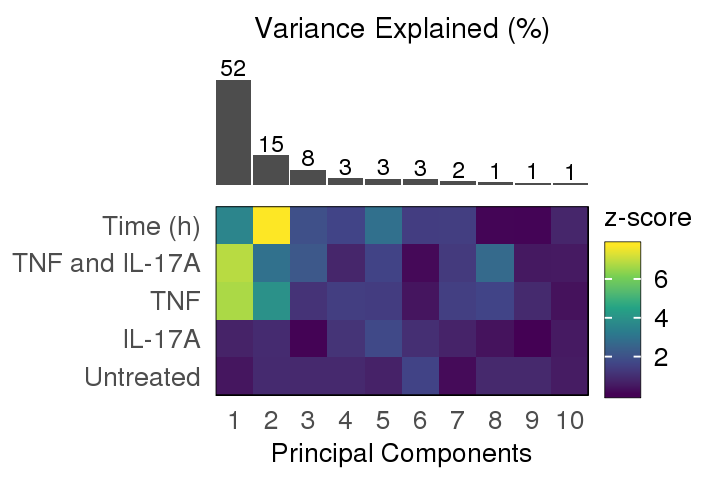

In [345]:
# m_pca <- summary(prcomp(t(m_exp)))

# m_pca_meta <- cbind.data.frame(meta, m_pca$x[,1:10])

# print(m_pca$importance[,1:6])


pca <- summary(prcomp(x = t(m_exp)))

pca$importance[,1:10]

pca_dat <- cbind(meta, as.data.frame(pca$x[,1:10]))

pca$rotation <- data.frame(
#   gene = gene_symbols[rownames(pca$rotation)],
  pca$rotation
)
corner(pca$rotation)
nrow(pca$rotation)

# ANOVA

# cols <- c(
#   "Time", "Dose"
# #  "Stimulation", "Time", "Dose", "Disease"
# #   "Plate", "Disease", "Cell_Line"
# )

# a <- rbindlist(lapply(cols, function(col) {
#   rbindlist(lapply(1:10, function(pc) {
#     a <- anova(aov(formula = as.formula(sprintf("PC%s ~ %s", pc, col)), data = pca_dat))
#     a <- broom::tidy(a)
#     a$pc <- pc
#     a
#   }))
# }))
# a <- a[!is.na(a$p.value),]
# a$pc <- factor(a$pc)
# a %>% arrange(p.value) %>% head

# a$log10p <- -log10(a$p.value)
# a$zscore <- qnorm(1 - (a$p.value / 2))
# a$zscore[!is.finite(a$zscore)] <- max(a$zscore[is.finite(a$zscore)])

pca_dat$Time <- as.numeric(as.character(pca_dat$Time))

pca_dat$Treatment <- forcats::fct_relevel(pca_dat$Treatment, c("MEDIA", "UNTREATED", "IL17", "TNF", "TNF_IL17"))

labels_Treatment <- c(
  "UNTREATED" = "Untreated",
  "MEDIA" = "Media",
  "IL17" = "IL-17A",
  "TNF" = "TNF",
  "TNF_IL17" = "TNF and IL-17A",
  "Time" = "Time (h)"
)

# Linear model (almost the same result)
a <- rbindlist(lapply(1:10, function(pc) {
  a <- lm(formula = as.formula(sprintf("PC%s ~ Time + Treatment", pc)), data = pca_dat)
  a <- broom::tidy(a)
  a$pc <- pc
  a
}))
a <- a[!is.na(a$p.value),]
a$pc <- factor(a$pc)
a$log10p <- -log10(a$p.value)
a$zscore <- qnorm(1 - (a$p.value / 2))
a$zscore[!is.finite(a$zscore)] <- max(a$zscore[is.finite(a$zscore)])
head(a)

a$term <- str_replace_all(a$term, "Treatment", "")
a$term <- factor(a$term, c("UNTREATED", "MEDIA", "IL17", "TNF", "TNF_IL17", "Time"))

p1 <- ggplot(a %>% filter(term != "(Intercept)"), aes(x = pc, y = term, fill = zscore)) +
geom_tile() +
# scale_fill_gradient2(low = "white", high = "black") +
scale_fill_viridis_c() + #name = bquote("-log"[10]~"P")) +
# scale_fill_distiller(direction = 1, palette = "Greys") +
scale_x_discrete(expand = c(0, 0)) +
scale_y_discrete(
  expand = c(0, 0),
  labels = labels_Treatment
) +
guides(
  fill = guide_colorbar(title = "z-score",
    barheight = 6.5, barwidth = 1.5,
    frame.colour = "black", frame.linewidth = 0.6,
    ticks.linewidth = 1.5
  )
) +
theme_minimal(base_size = 20) +
# coord_equal() +
theme(
  axis.title = element_text(size = 16),
  legend.title = element_text(size = 16),
  panel.border = element_rect(fill = NA, size = 0.5),
  panel.grid = element_blank(),
  legend.position = "right",
  legend.box.spacing = unit(0, "lines"),
  plot.margin = margin(0, 0, 0, 0)
) +
labs(x = "Principal Components", y = NULL)

d <- janitor::clean_names(as.data.frame(t(pca$importance[,1:10]))) %>%
tibble::rownames_to_column("pc") %>%
mutate(pc = factor(as.integer(substr(pc, 3, 5))))

p2 <- ggplot() +
geom_col(width = 0.95,
  data = d, mapping = aes(x = pc, y = proportion_of_variance),
  fill = "grey30"
) +
scale_x_discrete(expand = c(0, 0)) +
scale_y_discrete(expand = c(0.1, 0)) +
geom_text(
  mapping = aes(x = 5.5, y = max(d$proportion_of_variance) * 1.5, label = "Variance Explained (%)"),
  size = 6
) +
geom_text(
  data = d, mapping = aes(
    x = pc, y = proportion_of_variance,
    label = sprintf("%.0f", proportion_of_variance * 100)
  ),
  size = 5,
  vjust = -0.2
) +
theme(axis.line.x = element_blank(), axis.text = element_blank(), axis.ticks = element_blank(), panel.border = element_blank()) +
labs(x = NULL, y = NULL) +
theme(plot.title = element_text(size = 16), plot.margin = margin(0, 0, 0, 0))

options(repr.plot.width = 6, repr.plot.height = 4)

show_plot((p2 / p1) + plot_layout(ncol = 1), name = "rnaseq-data-1-pca-variance")

In [333]:
# m_pca <- summary(prcomp(t(m_exp[rowSds(m_exp) > 1,])))
m_pca <- summary(prcomp(t(m_exp)))

m_pca_meta <- cbind.data.frame(meta, m_pca$x[,1:10])

print(m_pca$importance[,1:6])

                            PC1      PC2      PC3     PC4      PC5      PC6
Standard deviation     28.70524 15.24831 10.90676 7.16780 6.865646 6.435335
Proportion of Variance  0.52112  0.14705  0.07523 0.03249 0.029810 0.026190
Cumulative Proportion   0.52112  0.66816  0.74340 0.77589 0.805700 0.831890


In [334]:
m_pca$varlabs <- sprintf("PC%s (%s%%)", 1:10, signif(m_pca$importance[2,1:10] * 100, 2))

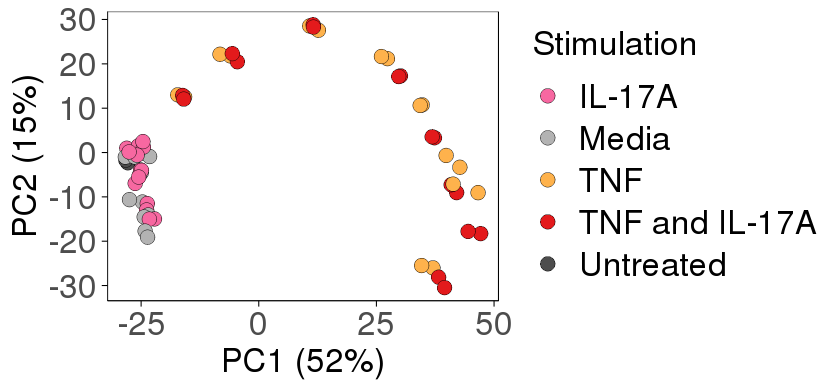

In [335]:
options(repr.plot.width = 7, repr.plot.height = 3.25)

p <- ggplot(m_pca_meta) +
geom_point(aes(PC1, PC2, fill = Treatment), shape = 21, size = 4, stroke = 0.2) +
scale_fill_manual(
  name = "Stimulation",
  values = meta_colors$Treatment,
  labels = c(
    "IL17" = "IL-17A",
    "MEDIA" = "Media",
    "TNF" = "TNF",
    "TNF_IL17" = "TNF and IL-17A",
    "UNTREATED" = "Untreated"
  )
) +
labs(x = m_pca$varlabs[1], y = m_pca$varlabs[2]) +
theme(legend.key.height = unit(1.75, "lines"),
  plot.title = element_text(face = "italic", size = 20),
  axis.title = element_text(size = 20),
  axis.text = element_text(size = 20),
  legend.title = element_text(size = 20),
  legend.text = element_text(size = 20),
  axis.ticks   = element_line(colour = "black", size = 0.3),
  panel.border = element_rect(size = 0.3, fill = NA),
  axis.line    = element_blank()
)

show_plot(p, name = "microarray-data-1-pca-1-2-stimulation")

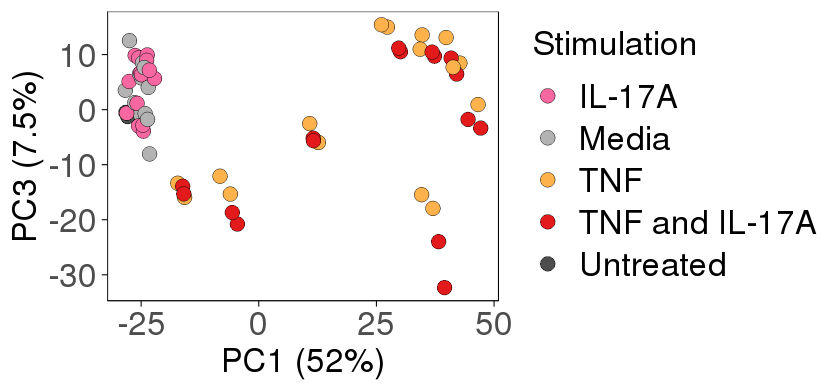

In [336]:
options(repr.plot.width = 7, repr.plot.height = 3.25)

p <- ggplot(m_pca_meta) +
geom_point(aes(PC1, PC3, fill = Treatment), shape = 21, size = 4, stroke = 0.2) +
scale_fill_manual(
  name = "Stimulation",
  values = meta_colors$Treatment,
  labels = c(
    "IL17" = "IL-17A",
    "MEDIA" = "Media",
    "TNF" = "TNF",
    "TNF_IL17" = "TNF and IL-17A",
    "UNTREATED" = "Untreated"
  )
) +
labs(x = m_pca$varlabs[1], y = m_pca$varlabs[3]) +
theme(legend.key.height = unit(1.75, "lines"),
  plot.title = element_text(face = "italic", size = 20),
  axis.title = element_text(size = 20),
  axis.text = element_text(size = 20),
  legend.title = element_text(size = 20),
  legend.text = element_text(size = 20),
  axis.ticks   = element_line(colour = "black", size = 0.3),
  panel.border = element_rect(size = 0.3, fill = NA),
  axis.line    = element_blank()
)

show_plot(p, name = "microarray-data-1-pca-1-3-stimulation")

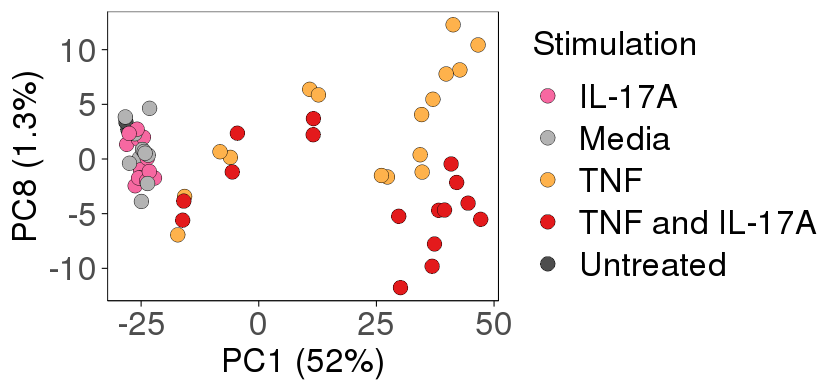

In [337]:
options(repr.plot.width = 7, repr.plot.height = 3.25)

p <- ggplot(m_pca_meta) +
geom_point(aes(PC1, PC8, fill = Treatment), shape = 21, size = 4, stroke = 0.2) +
scale_fill_manual(
  name = "Stimulation",
  values = meta_colors$Treatment,
  labels = c(
    "IL17" = "IL-17A",
    "MEDIA" = "Media",
    "TNF" = "TNF",
    "TNF_IL17" = "TNF and IL-17A",
    "UNTREATED" = "Untreated"
  )
) +
labs(x = m_pca$varlabs[1], y = m_pca$varlabs[8]) +
theme(legend.key.height = unit(1.75, "lines"),
  plot.title = element_text(face = "italic", size = 20),
  axis.title = element_text(size = 20),
  axis.text = element_text(size = 20),
  legend.title = element_text(size = 20),
  legend.text = element_text(size = 20),
  axis.ticks   = element_line(colour = "black", size = 0.3),
  panel.border = element_rect(size = 0.3, fill = NA),
  axis.line    = element_blank()
)

show_plot(p, name = "microarray-data-1-pca-1-8-stimulation")

In [338]:
# print(meta_colors$Time)

meta_colors$Time.bak <- meta_colors$Time
meta_colors$Time <- RColorBrewer::brewer.pal(n = 9, "Greys")

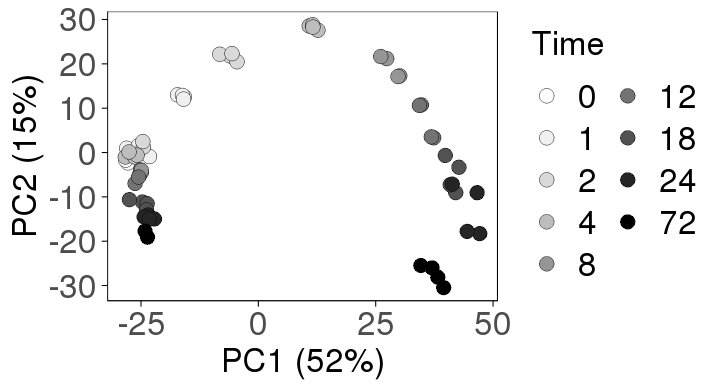

In [339]:
options(repr.plot.width = 6, repr.plot.height = 3.25)

p <- ggplot(m_pca_meta) +
geom_point(aes(PC1, PC2, fill = Time), shape = 21, size = 4, stroke = 0.2) +
scale_fill_manual(values = meta_colors$Time) +
labs(x = m_pca$varlabs[1], y = m_pca$varlabs[2]) +
guides(fill = guide_legend(ncol = 2)) +
theme(legend.key.height = unit(1.75, "lines"),
  plot.title = element_text(face = "italic", size = 20),
  axis.title = element_text(size = 20),
  axis.text = element_text(size = 20),
  legend.title = element_text(size = 20),
  legend.text = element_text(size = 20),
  axis.ticks   = element_line(colour = "black", size = 0.3),
  panel.border = element_rect(size = 0.3, fill = NA),
  axis.line    = element_blank()
)

show_plot(p, name = "microarray-data-1-pca-1-2-time")

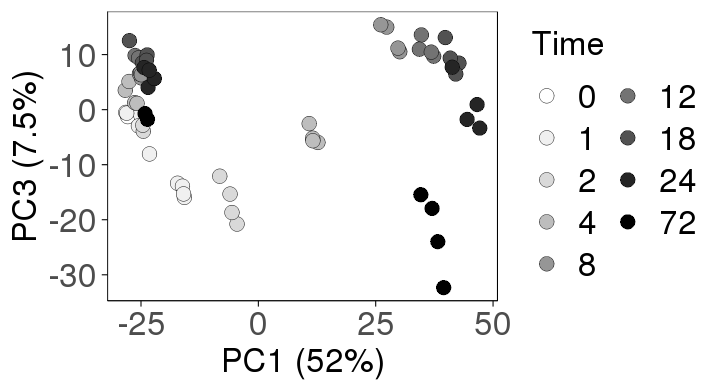

In [340]:
options(repr.plot.width = 6, repr.plot.height = 3.25)

p <- ggplot(m_pca_meta) +
geom_point(aes(PC1, PC3, fill = Time), shape = 21, size = 4, stroke = 0.2) +
scale_fill_manual(values = meta_colors$Time) +
labs(x = m_pca$varlabs[1], y = m_pca$varlabs[3]) +
guides(fill = guide_legend(ncol = 2)) +
theme(legend.key.height = unit(1.75, "lines"),
  plot.title = element_text(face = "italic", size = 20),
  axis.title = element_text(size = 20),
  axis.text = element_text(size = 20),
  legend.title = element_text(size = 20),
  legend.text = element_text(size = 20),
  axis.ticks   = element_line(colour = "black", size = 0.3),
  panel.border = element_rect(size = 0.3, fill = NA),
  axis.line    = element_blank()
)

show_plot(p, name = "microarray-data-1-pca-1-3-time")

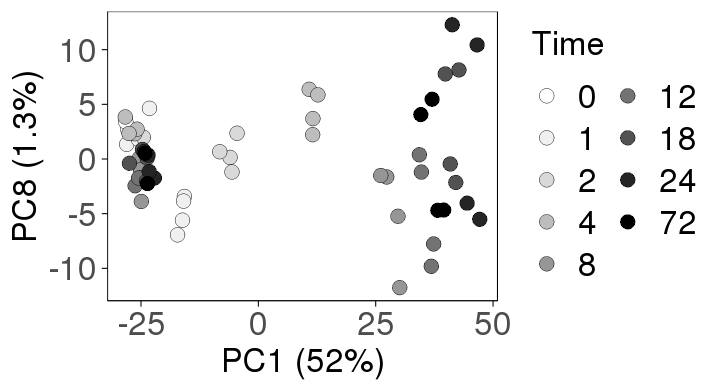

In [341]:
options(repr.plot.width = 6, repr.plot.height = 3.25)

p <- ggplot(m_pca_meta) +
geom_point(aes(PC1, PC8, fill = Time), shape = 21, size = 4, stroke = 0.2) +
scale_fill_manual(values = meta_colors$Time) +
labs(x = m_pca$varlabs[1], y = m_pca$varlabs[8]) +
guides(fill = guide_legend(ncol = 2)) +
theme(legend.key.height = unit(1.75, "lines"),
  plot.title = element_text(face = "italic", size = 20),
  axis.title = element_text(size = 20),
  axis.text = element_text(size = 20),
  legend.title = element_text(size = 20),
  legend.text = element_text(size = 20),
  axis.ticks   = element_line(colour = "black", size = 0.3),
  panel.border = element_rect(size = 0.3, fill = NA),
  axis.line    = element_blank()
)

show_plot(p, name = "microarray-data-1-pca-1-8-time")

## PCA

In [71]:
scale_rows <- function(x, ...) t(scale(t(x, ...)))

In [76]:
m_pca <- summary(prcomp(scale(scale_rows(m_exp))))

m_pca_meta <- cbind.data.frame(meta, m_pca$rotation[,1:10])

In [100]:
m_pca$importance[2,1:5]

PC1     PC2     PC3     PC4     PC5 
0.26425 0.11303 0.06906 0.05173 0.03698

In [105]:
m_pca$varlabs <- sprintf("PC%s (%s%%)", 1:10, signif(m_pca$importance[2,1:10] * 100, 2))

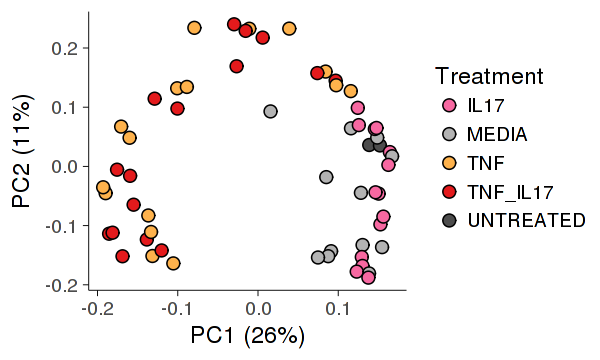

In [107]:
options(repr.plot.width = 5, repr.plot.height = 3)

ggplot(m_pca_meta) +
geom_point(aes(PC1, PC2, fill = Treatment), shape = 21, size = 3) +
scale_fill_manual(values = meta_colors$Treatment) +
labs(x = m_pca$varlabs[1], y = m_pca$varlabs[2])

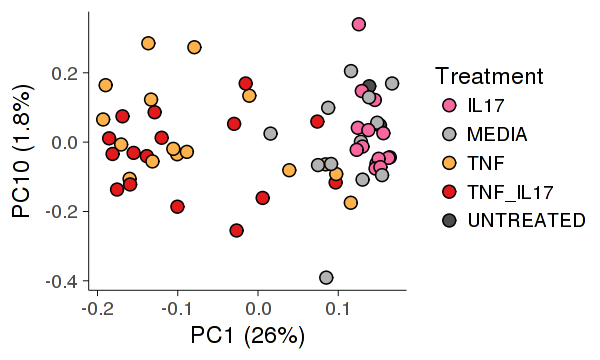

In [129]:
options(repr.plot.width = 5, repr.plot.height = 3)

ggplot(m_pca_meta) +
geom_point(aes(PC1, PC10, fill = Treatment), shape = 21, size = 3) +
scale_fill_manual(values = meta_colors$Treatment) +
labs(x = m_pca$varlabs[1], y = m_pca$varlabs[10])

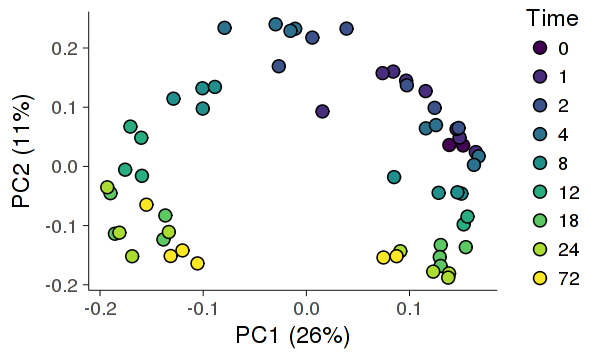

In [148]:
options(repr.plot.width = 5, repr.plot.height = 3)

ggplot(m_pca_meta) +
geom_point(aes(PC1, PC2, fill = Time), shape = 21, size = 3) +
scale_fill_manual(values = meta_colors$Time) +
labs(x = m_pca$varlabs[1], y = m_pca$varlabs[2])

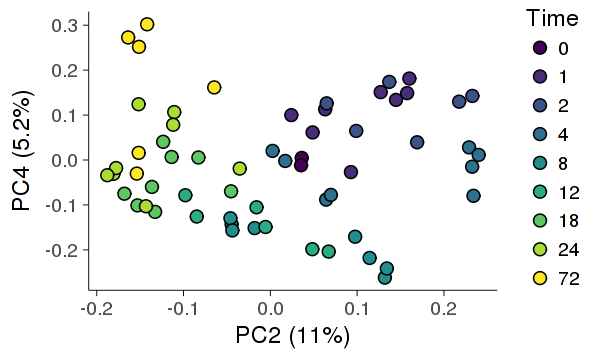

In [146]:
options(repr.plot.width = 5, repr.plot.height = 3)

ggplot(m_pca_meta) +
geom_point(aes(PC2, PC4, fill = Time), shape = 21, size = 3) +
scale_fill_manual(values = meta_colors$Time) +
labs(x = m_pca$varlabs[2], y = m_pca$varlabs[4])

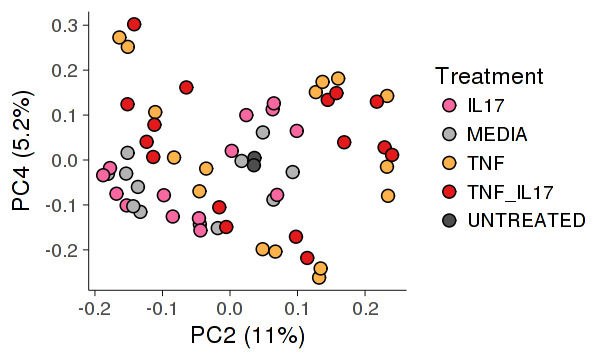

In [147]:
options(repr.plot.width = 5, repr.plot.height = 3)

ggplot(m_pca_meta) +
geom_point(aes(PC2, PC4, fill = Treatment), shape = 21, size = 3) +
scale_fill_manual(values = meta_colors$Treatment) +
labs(x = m_pca$varlabs[2], y = m_pca$varlabs[4])

In [93]:
m_pca_meta$TNF_IL17 <- NA
m_pca_meta$TNF_IL17[m_pca_meta$Treatment == "TNF"] <- FALSE
m_pca_meta$TNF_IL17[m_pca_meta$Treatment == "TNF_IL17"] <- TRUE

cols <- c("Time", "Treatment", "Replicate", "common_percent", "TNF_IL17")
pcs <- sprintf("PC%s", 1:10)

m_pca_anova <- do.call(rbind, lapply(pcs, function(pc) {
    do.call(rbind, lapply(cols, function(col) {
        f <- as.formula(sprintf("%s ~ %s", pc, col))
        x <- broom::tidy(anova(aov(
          formula = f, data = m_pca_meta
        )))[1,]
        x$pc <- pc
        x
    }))
}))

### ANOVA for each PC

Warning message:
“partial match of 'just' to 'justification'”

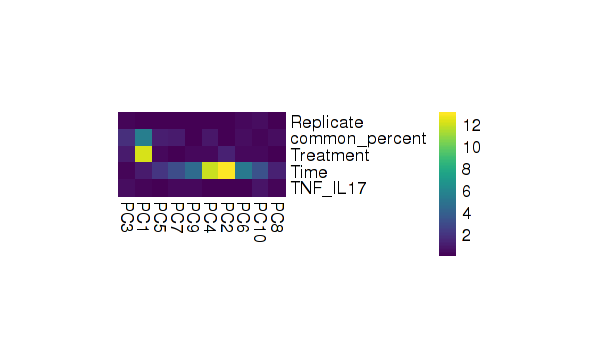

In [141]:
m_pca_anova_mat <- reshape2::dcast(data = m_pca_anova, formula = term ~ pc, value.var = "p.value")
rownames(m_pca_anova_mat) <- m_pca_anova_mat$term
m_pca_anova_mat$term <- NULL

m_pca_anova_mat <- as.matrix(-log10(m_pca_anova_mat))

x <- seriate(m_pca_anova_mat, method = "BEA_TSP")
m_pca_anova_mat <- m_pca_anova_mat[x[[1]], x[[2]]]

pheatmap(
    mat = m_pca_anova_mat,
#     color = colorRampPalette(BuenColors::jdb_palettes$solar_flare)(100),
    color = viridis::viridis(100),
#     color = colorRampPalette(RColorBrewer::brewer.pal(9, "Greys"))(100),
    cluster_rows = FALSE,
    cluster_cols = FALSE,
#     scale = "row",
    border_color = NA,
    cellwidth = 10,
    cellheight = 10
)